In [1]:
# === imports ===
import sys, os, platform, hashlib, json, random, time, math
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

RUN_ID = f"best_backpacker_{datetime.now().strftime('%Y%m%d_%H%M%S')}_seed{SEED}"

# Version banner
env_info = {
    "python_version": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy_version": np.__version__,
    "pandas_version": pd.__version__,
    "run_id": RUN_ID,
}
print(json.dumps(env_info, indent=2))


{
  "python_version": "3.13.0",
  "platform": "Windows-10-10.0.19045-SP0",
  "numpy_version": "2.1.3",
  "pandas_version": "2.2.3",
  "run_id": "best_backpacker_20251110_173036_seed42"
}


In [2]:
# ===  Define paths ===
from pathlib import Path

ITEMS_CSV       = Path(r'F:\Downloads 2\items.csv')
SYNERGIES_CSV   = Path(r'F:\Downloads 2\synergies.csv')
SCENARIOS_CSV   = Path(r'F:\Downloads 2\scenarios.csv')
DIV_BOUNDS_CSV  = Path(r'F:\Downloads 2\divisible_bounds.csv')
README_TXT      = Path(r'F:\Downloads 2\README_BestBackpacker.txt')

# Echo the configured paths
print("Configured paths:")
for p in [ITEMS_CSV, SYNERGIES_CSV, SCENARIOS_CSV, DIV_BOUNDS_CSV, README_TXT]:
    print("-", p)


Configured paths:
- F:\Downloads 2\items.csv
- F:\Downloads 2\synergies.csv
- F:\Downloads 2\scenarios.csv
- F:\Downloads 2\divisible_bounds.csv
- F:\Downloads 2\README_BestBackpacker.txt


In [3]:
# === intro stats ===

def file_digest(path: Path, algo="sha256", chunk=1<<16):
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def try_read_csv(path, **kwargs):
    try:
        df = pd.read_csv(path, **kwargs)
        return df, None
    except Exception as e:
        return None, str(e)

summary = {"run_id": RUN_ID, "files": {}}

# Check files and collect basic info if available
for label, p in {
    "items": ITEMS_CSV,
    "synergies": SYNERGIES_CSV,
    "scenarios": SCENARIOS_CSV,
    "divisible_bounds": DIV_BOUNDS_CSV,
    "readme": README_TXT,
}.items():
    entry = {"path": str(p), "exists": Path(p).exists()}
    if entry["exists"] and label != "readme":
        df, err = try_read_csv(p)
        if err is None:
            entry.update({
                "rows": int(df.shape[0]),
                "cols": int(df.shape[1]),
                "columns": list(df.columns[:20]),
            })
            if label == "items":
                # quick counts if standard columns exist
                if "divisible" in df.columns:
                    entry["divisible_count"] = int((df["divisible"]==1).sum())
                    entry["indivisible_count"] = int((df["divisible"]==0).sum())
            if label == "scenarios":
                for col in ["T_hours","C_weight_kg","C_volume_l","B_budget_usd"]:
                    if col in df.columns:
                        entry[f"{col}_min"] = float(df[col].min())
                        entry[f"{col}_median"] = float(df[col].median())
                        entry[f"{col}_max"] = float(df[col].max())
        else:
            entry["read_error"] = err
    elif entry["exists"] and label == "readme":
        try:
            with open(p, "r", encoding="utf-8", errors="ignore") as f:
                head = f.read(800)
            entry["preview"] = head
            entry["digest_sha256"] = file_digest(p)
        except Exception as e:
            entry["read_error"] = str(e)
    summary["files"][label] = entry

print(json.dumps(summary, indent=2))


{
  "run_id": "best_backpacker_20251110_173036_seed42",
  "files": {
    "items": {
      "path": "F:\\Downloads 2\\items.csv",
      "exists": true,
      "rows": 28,
      "cols": 19,
      "columns": [
        "id",
        "name",
        "category",
        "divisible",
        "unit",
        "weight_kg_per_unit",
        "volume_l_per_unit",
        "price_usd_per_unit",
        "max_units",
        "alpha",
        "beta_T_per_hour",
        "beta_altitude_per_1000m",
        "beta_temp_cold_per_c",
        "beta_temp_hot_per_c",
        "nights_req",
        "t_threshold_hours",
        "gamma_after_threshold",
        "diminish_after_units",
        "notes"
      ],
      "divisible_count": 4,
      "indivisible_count": 24
    },
    "synergies": {
      "path": "F:\\Downloads 2\\synergies.csv",
      "exists": true,
      "rows": 9,
      "cols": 7,
      "columns": [
        "item_id_1",
        "item_id_2",
        "effect",
        "mode",
        "delta_value",
        "

In [4]:
# === Load data for 2.1 (valuation & coalition) ===
import pandas as pd
from pathlib import Path

# Uses the paths as before
def _must_exist(path: Path):
    if not Path(path).exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return path

ITEMS_DF      = pd.read_csv(_must_exist(ITEMS_CSV))
SYNERGIES_DF  = pd.read_csv(_must_exist(SYNERGIES_CSV))
SCENARIOS_DF  = pd.read_csv(_must_exist(SCENARIOS_CSV))
DIV_BOUNDS_DF = pd.read_csv(_must_exist(DIV_BOUNDS_CSV))

# Indices for fast lookup
ITEMS_BY_ID       = ITEMS_DF.set_index("id", drop=False)
DIV_BOUNDS_BY_ID  = DIV_BOUNDS_DF.set_index("item_id", drop=False)

print("Loaded:")
print(" items:", ITEMS_DF.shape, list(ITEMS_DF.columns))
print(" synergies:", SYNERGIES_DF.shape, list(SYNERGIES_DF.columns))
print(" scenarios:", SCENARIOS_DF.shape, list(SCENARIOS_DF.columns))
print(" divisible_bounds:", DIV_BOUNDS_DF.shape, list(DIV_BOUNDS_DF.columns))


Loaded:
 items: (28, 19) ['id', 'name', 'category', 'divisible', 'unit', 'weight_kg_per_unit', 'volume_l_per_unit', 'price_usd_per_unit', 'max_units', 'alpha', 'beta_T_per_hour', 'beta_altitude_per_1000m', 'beta_temp_cold_per_c', 'beta_temp_hot_per_c', 'nights_req', 't_threshold_hours', 'gamma_after_threshold', 'diminish_after_units', 'notes']
 synergies: (9, 7) ['item_id_1', 'item_id_2', 'effect', 'mode', 'delta_value', 'condition', 'description']
 scenarios: (5, 11) ['scenario_id', 'name', 'T_hours', 'nights', 'altitude_m', 'avg_temp_c', 'C_weight_kg', 'C_volume_l', 'B_budget_usd', 'bear_country', 'water_sources']
 divisible_bounds: (4, 4) ['item_id', 'min_units', 'max_units', 'step_units']


In [5]:
# ===  Stand-alone utility u_i ===
from dataclasses import dataclass
from typing import Dict, Optional

@dataclass(frozen=True)
class Context:
    T_hours: float
    altitude_m: float
    tempC: float
    nights: int = 0  # kept for possible conditions in synergies

def cold_excess(tempC: float) -> float:
    return max(0.0, 12.0 - float(tempC))

def heat_excess(tempC: float) -> float:
    return max(0.0, float(tempC) - 20.0)

def units_clip(item_id: str, raw_units: float) -> float:
    """Apply divisible bounds if present; otherwise return raw_units."""
    if item_id in DIV_BOUNDS_BY_ID.index:
        row = DIV_BOUNDS_BY_ID.loc[item_id]
        mn, mx, step = float(row["min_units"]), float(row["max_units"]), float(row["step_units"])
        # Snap to grid defined by step
        snapped = mn + round((max(mn, min(mx, raw_units)) - mn) / step) * step
        return float(snapped)
    return float(raw_units)

def u_item(item_id: str, ctx: Context, units: Optional[float] = None) -> float:
    """
    Stand-alone utility for item i at context ctx.
    If item is divisible and units is provided, utility scales linearly with units.
    If item is indivisible, units are ignored and treated as 1.
    """
    row = ITEMS_BY_ID.loc[item_id]

    alpha  = float(row.get("alpha", 0.0))
    bT     = float(row.get("beta_T_per_hour", 0.0))
    balt   = float(row.get("beta_altitude_per_1000m", 0.0))
    bcold  = float(row.get("beta_temp_cold_per_c", 0.0))
    bhot   = float(row.get("beta_temp_hot_per_c", 0.0))
    t_thr  = float(row.get("t_threshold_hours", 1e18))  
    gamma  = float(row.get("gamma_after_threshold", 0.0))

    # Base utility per unit
    base = (
        alpha
        + bT * ctx.T_hours
        + balt * (ctx.altitude_m / 1000.0)
        + bcold * cold_excess(ctx.tempC)
        + bhot  * heat_excess(ctx.tempC)
        + (gamma if ctx.T_hours >= t_thr else 0.0)
    )

    # Scale by units if divisible
    is_divisible = int(row.get("divisible", 0)) == 1
    if is_divisible:
        u = base * (units_clip(item_id, 0.0 if units is None else float(units)))
    else:
        u = base  # single unit

    return float(u)


In [6]:
# === Safe condition evaluation for synergies ===
import ast
from typing import Any, Callable, Set

class SafeCond(ast.NodeVisitor):
    ALLOWED_NAMES = {"T", "nights", "altitude_m", "tempC"}
    ALLOWED_OPS = (ast.And, ast.Or, ast.Not, ast.Gt, ast.GtE, ast.Lt, ast.LtE, ast.Eq, ast.NotEq)

    def __init__(self, vars_dict: Dict[str, Any], has_func: Callable[[str], bool]):
        self.vars = vars_dict
        self.has = has_func

    def visit_Module(self, node):  # type: ignore
        return self.visit(node.body[0].value)

    def visit_Expr(self, node):  # type: ignore
        return self.visit(node.value)

    def visit_Name(self, node):  # type: ignore
        if node.id not in self.ALLOWED_NAMES:
            raise ValueError(f"Illegal name in condition: {node.id}")
        return self.vars[node.id]

    def visit_Constant(self, node):  # type: ignore
        return node.value

    def visit_UnaryOp(self, node):  # type: ignore
        if not isinstance(node.op, ast.Not):
            raise ValueError("Only 'not' unary op is allowed")
        return not self.visit(node.operand)

    def visit_BoolOp(self, node):  # type: ignore
        if not isinstance(node.op, (ast.And, ast.Or)):
            raise ValueError("Only 'and'/'or' are allowed")
        vals = [self.visit(v) for v in node.values]
        if isinstance(node.op, ast.And):
            return all(vals)
        return any(vals)

    def visit_Compare(self, node):  # type: ignore
        left = self.visit(node.left)
        for op, right_node in zip(node.ops, node.comparators):
            right = self.visit(right_node)
            if isinstance(op, ast.Gt):
                ok = left > right
            elif isinstance(op, ast.GtE):
                ok = left >= right
            elif isinstance(op, ast.Lt):
                ok = left < right
            elif isinstance(op, ast.LtE):
                ok = left <= right
            elif isinstance(op, ast.Eq):
                ok = left == right
            elif isinstance(op, ast.NotEq):
                ok = left != right
            else:
                raise ValueError("Illegal comparison op")
            if not ok:
                return False
            left = right
        return True

    def visit_Call(self, node):  # type: ignore
        # supports has("item_id")
        if not isinstance(node.func, ast.Name) or node.func.id != "has":
            raise ValueError("Only has(\"item_id\") calls are allowed")
        if len(node.args) != 1 or not isinstance(node.args[0], ast.Constant):
            raise ValueError("has() expects a single string literal")
        return bool(self.has(str(node.args[0].value)))

def eval_condition(cond_str: str, vars_dict: Dict[str, Any], has_func: Callable[[str], bool]) -> bool:
    cond_str = cond_str.strip()
    if cond_str == "" or cond_str.lower() in {"true", "1"}:
        return True
    if cond_str.lower() in {"false", "0"}:
        return False
    tree = ast.parse(cond_str, mode="exec")
    return bool(SafeCond(vars_dict, has_func).visit(tree))


In [7]:
# === Coalition value v(S,T) with synergies ===
from typing import Tuple

def coalition_value(selection: Dict[str, float], ctx: Context) -> Tuple[float, Dict[str, float]]:
    """
    selection: {item_id: units}; indivisible items should have units=1 if included
    returns: (total_value, per_item_utilities)
    """
    # Per-item contributions
    per_item_u = {}
    present: Set[str] = set([iid for iid, qty in selection.items() if qty and qty > 0])

    # Base sum
    total = 0.0
    for iid, qty in selection.items():
        per_item_u[iid] = u_item(iid, ctx, units=qty)
        total += per_item_u[iid]

    # Synergy adjustments
    vars_dict = {
        "T": ctx.T_hours,
        "nights": ctx.nights,
        "altitude_m": ctx.altitude_m,
        "tempC": ctx.tempC,
    }
    def has(item_id: str) -> bool:
        return item_id in present

    for _, row in SYNERGIES_DF.iterrows():
        a = str(row["item_id_1"])
        b = str(row["item_id_2"])
        if a in present and b in present:
            cond = str(row.get("condition", "") or "")
            try:
                ok = eval_condition(cond, vars_dict, has)
            except Exception:
                ok = False
            if ok:
                mode = str(row.get("mode", "additive")).lower().strip()
                delta = float(row.get("delta_value", 0.0))
                if mode == "additive":
                    total += delta
                elif mode == "multiplier":
                    total *= delta
                else:
                    # Unknown mode: ignore quietly
                    pass

    return float(total), per_item_u


In [8]:
# === Optional sanity: inspect a scenario and a few items ===
def context_from_scenario(scn_row) -> Context:
    return Context(
        T_hours     = float(scn_row["T_hours"]),
        altitude_m  = float(scn_row["altitude_m"]),
        tempC       = float(scn_row["avg_temp_c"]),
        nights      = int(scn_row.get("nights", 0)),
    )

def preview_item_utils(scn_id: str, item_ids: list, quantities: Dict[str, float]):
    scn = SCENARIOS_DF.set_index("scenario_id").loc[scn_id]
    ctx = context_from_scenario(scn)
    total, per_item = coalition_value(quantities, ctx)
    print("Scenario:", scn_id, "| T:", ctx.T_hours, "H:", ctx.altitude_m, "tempC:", ctx.tempC, "nights:", ctx.nights)
    for iid in item_ids:
        q = quantities.get(iid, 0)
        print(f"  {iid}: units={q}  u_i={per_item.get(iid, 0):.4f}")
    print("Coalition value v(S,T) =", f"{total:.4f}")



In [9]:
# ===  Helpers for unconstrained Shapley ===
from typing import List, Dict, Iterable

def default_quantities(item_ids: Iterable[str]) -> Dict[str, float]:
    """
    Build a quantities dict for a set of items.
    - indivisible items -> 1
    - divisible items   -> use min_units from DIV_BOUNDS if available, else 1.0
    """
    q = {}
    for iid in item_ids:
        row = ITEMS_BY_ID.loc[iid]
        if int(row["divisible"]) == 1:
            if iid in DIV_BOUNDS_BY_ID.index:
                q[iid] = float(DIV_BOUNDS_BY_ID.loc[iid]["min_units"])
            else:
                q[iid] = 1.0
        else:
            q[iid] = 1.0
    return q

def selection_from_order(order: List[str], upto_index_exclusive: int, base_quantities: Dict[str, float]) -> Dict[str, float]:
    """Build Sπ(i) given a permutation and cut position."""
    S = {}
    for j in range(upto_index_exclusive):
        iid = order[j]
        S[iid] = base_quantities.get(iid, 1.0)
    return S


In [10]:
# === Exact Shapley (small n) and MC Shapley (permutations) ===
from typing import Sequence, Tuple
from itertools import permutations
import numpy as np
import math

def shapley_exact_unconstrained(item_ids: Sequence[str], ctx: Context, quantities: Dict[str, float] | None = None) -> Dict[str, float]:
    """
    Exact Shapley by summing marginal contributions over all permutations.
    WARNING: O(n!) — practical for n ≤ 8–9.
    """
    if quantities is None:
        quantities = default_quantities(item_ids)
    n = len(item_ids)
    phi = {iid: 0.0 for iid in item_ids}
    for order in permutations(item_ids, n):
        v_S = 0.0
        S = {}
        for k in range(n):
            i = order[k]
            v_before = v_S
            S[i] = quantities[i]
            v_after, _ = coalition_value(S, ctx)
            phi[i] += (v_after - v_before)
            v_S = v_after
    fact = math.factorial(n)
    for i in phi:
        phi[i] /= fact
    return phi

def shapley_mc_unconstrained(item_ids: Sequence[str], ctx: Context, n_samples: int = 10000,
                             quantities: Dict[str, float] | None = None, seed: int = 42) -> Dict[str, dict]:
    """
    Monte Carlo Shapley using random permutations.
    Returns dict[iid] = {'mean':..., 'se':..., 'ci95': (lo, hi)}
    """
    rng = np.random.default_rng(seed)
    if quantities is None:
        quantities = default_quantities(item_ids)
    m = len(item_ids)
    ids = list(item_ids)
    idx = np.arange(m)
    samples = {iid: [] for iid in ids}

    for _ in range(int(n_samples)):
        rng.shuffle(idx)
        order = [ids[j] for j in idx]
        S = {}
        v_S = 0.0
        for k in range(m):
            i = order[k]
            v_before = v_S
            S[i] = quantities[i]
            v_after, _ = coalition_value(S, ctx)
            samples[i].append(v_after - v_before)
            v_S = v_after

    out = {}
    for iid, arr in samples.items():
        a = np.asarray(arr, dtype=float)
        mean = float(a.mean())
        se   = float(a.std(ddof=1) / np.sqrt(len(a)))
        z    = 1.96
        out[iid] = {"mean": mean, "se": se, "ci95": (mean - z*se, mean + z*se)}
    return out


In [11]:
# === Runner: pick a scenario and a subset of items ===
def context_from_scenario_id(sid: str) -> Context:
    scn = SCENARIOS_DF.set_index("scenario_id").loc[sid]
    return Context(
        T_hours=float(scn["T_hours"]),
        altitude_m=float(scn["altitude_m"]),
        tempC=float(scn["avg_temp_c"]),
        nights=int(scn.get("nights", 0)),
    )

def run_unconstrained_shapley(sid: str, item_ids: list[str], n_samples: int = 20000,
                              exact_if_small: bool = False) -> dict:
    ctx = context_from_scenario_id(sid)
    if exact_if_small and len(item_ids) <= 8:
        phi = shapley_exact_unconstrained(item_ids, ctx)
        return {iid: {"mean": v, "se": 0.0, "ci95": (v, v)} for iid, v in phi.items()}
    return shapley_mc_unconstrained(item_ids, ctx, n_samples=n_samples)


In [13]:
# ===  IDs ===
from pprint import pprint

print("Scenario IDs and names:")
pprint(SCENARIOS_DF[["scenario_id","name","T_hours","C_weight_kg","C_volume_l","B_budget_usd"]].to_dict(orient="records"))

print("\nFirst 30 item ids with names and divisibility:")
pprint(ITEMS_DF[["id","name","divisible","category"]].to_dict(orient="records"))



Scenario IDs and names:
[{'B_budget_usd': 120.0,
  'C_volume_l': 22.0,
  'C_weight_kg': 8.0,
  'T_hours': 8,
  'name': 'Day hike – warm lowland',
  'scenario_id': 1},
 {'B_budget_usd': 300.0,
  'C_volume_l': 45.0,
  'C_weight_kg': 14.0,
  'T_hours': 26,
  'name': 'Overnighter – cool alpine',
  'scenario_id': 2},
 {'B_budget_usd': 350.0,
  'C_volume_l': 55.0,
  'C_weight_kg': 16.0,
  'T_hours': 36,
  'name': 'Weekend – mixed weather',
  'scenario_id': 3},
 {'B_budget_usd': 260.0,
  'C_volume_l': 40.0,
  'C_weight_kg': 12.0,
  'T_hours': 20,
  'name': 'Overnighter – hot & dry',
  'scenario_id': 4},
 {'B_budget_usd': 380.0,
  'C_volume_l': 60.0,
  'C_weight_kg': 18.0,
  'T_hours': 32,
  'name': 'Weekend – bear country',
  'scenario_id': 5}]

First 30 item ids with names and divisibility:
[{'category': 'supplies', 'divisible': 1, 'id': 1, 'name': 'Water'},
 {'category': 'supplies', 'divisible': 1, 'id': 2, 'name': 'Food (trail mix)'},
 {'category': 'supplies',
  'divisible': 1,
  'id': 3,


In [14]:
# === Robust context getter ===
def context_from_scenario(sid_or_idx) -> Context:
    df = SCENARIOS_DF
    if isinstance(sid_or_idx, int):
        row = df.iloc[sid_or_idx]
    else:
        idxed = df.set_index("scenario_id", drop=False)
        if sid_or_idx not in idxed.index:
            raise KeyError(f"scenario_id {sid_or_idx!r} not found. "
                           f"Use Cell 2.2d to inspect valid ids.")
        row = idxed.loc[sid_or_idx]
    return Context(
        T_hours=float(row["T_hours"]),
        altitude_m=float(row["altitude_m"]),
        tempC=float(row["avg_temp_c"]),
        nights=int(row.get("nights", 0)),
    )


In [15]:
# === Runners that call your Shapley functions with valid context ===
def run_unconstrained_shapley_by_id(sid: str, item_ids: list[str], n_samples: int = 20000,
                                    exact_if_small: bool = False) -> dict:
    ctx = context_from_scenario(sid)
    if exact_if_small and len(item_ids) <= 8:
        phi = shapley_exact_unconstrained(item_ids, ctx)
        return {iid: {"mean": v, "se": 0.0, "ci95": (v, v)} for iid, v in phi.items()}
    return shapley_mc_unconstrained(item_ids, ctx, n_samples=n_samples)

def run_unconstrained_shapley_by_idx(idx: int, item_ids: list[str], n_samples: int = 20000,
                                     exact_if_small: bool = False) -> dict:
    ctx = context_from_scenario(idx)
    if exact_if_small and len(item_ids) <= 8:
        phi = shapley_exact_unconstrained(item_ids, ctx)
        return {iid: {"mean": v, "se": 0.0, "ci95": (v, v)} for iid, v in phi.items()}
    return shapley_mc_unconstrained(item_ids, ctx, n_samples=n_samples)


In [20]:
# context from integer scenario_id
def context_from_scenario_idnum(sid: int) -> Context:
    row = SCENARIOS_DF.set_index("scenario_id").loc[int(sid)]
    return Context(
        T_hours=float(row["T_hours"]),
        altitude_m=float(row["altitude_m"]),
        tempC=float(row["avg_temp_c"]),
        nights=int(row.get("nights", 0)),
    )

# run MC Shapley for integer item ids
def run_unconstrained_shapley_by_idnum(sid: int, item_ids: list[int],
                                       n_samples: int = 20000,
                                       exact_if_small: bool = False) -> dict:
    ctx = context_from_scenario_idnum(sid)
    if exact_if_small and len(item_ids) <= 8:
        phi = shapley_exact_unconstrained(item_ids, ctx)
        return {iid: {"mean": v, "se": 0.0, "ci95": (v, v)} for iid, v in phi.items()}
    return shapley_mc_unconstrained(item_ids, ctx, n_samples=n_samples)

#  pretty print
def print_shapley_summary(res: dict):
    rows = sorted(
        ((iid, d["mean"], d["se"], d["ci95"][0], d["ci95"][1]) for iid, d in res.items()),
        key=lambda x: -x[1]
    )
    print("id  mean       se         ci95_lo    ci95_hi")
    for r in rows:
        print(f"{r[0]:<3d} {r[1]:>10.4f} {r[2]:>10.4f} {r[3]:>10.4f} {r[4]:>10.4f}")

# now
res = run_unconstrained_shapley_by_idnum(
    2,                  # scenario_id = 2  (Overnighter – cool alpine)
    [1, 2, 7, 8, 4, 5], # item ids: Water, Food, Tent 2P, Sleeping bag, Stove, Fuel canister
    n_samples=20000,
    exact_if_small=False
)
print_shapley_summary(res)
res



id  mean       se         ci95_lo    ci95_hi
2       9.3300     0.0000     9.3300     9.3300
1       8.0600     0.0000     8.0600     8.0600
5       2.7600     0.0000     2.7600     2.7600
8       2.7040     0.0000     2.7040     2.7040
7       2.5840     0.0000     2.5840     2.5840
4       2.0200     0.0000     2.0200     2.0200


{1: {'mean': 8.060000000000002,
  'se': 1.668281015178944e-17,
  'ci95': (8.060000000000002, 8.060000000000002)},
 2: {'mean': 9.329999999999998,
  'se': 4.68394264910805e-18,
  'ci95': (9.329999999999998, 9.329999999999998)},
 7: {'mean': 2.5840000000000005,
  'se': 5.3137766911297146e-18,
  'ci95': (2.5840000000000005, 2.5840000000000005)},
 8: {'mean': 2.7040000000000006,
  'se': 5.436965071265069e-18,
  'ci95': (2.7040000000000006, 2.7040000000000006)},
 4: {'mean': 2.0199999999999996,
  'se': 2.6879077402374097e-18,
  'ci95': (2.0199999999999996, 2.0199999999999996)},
 5: {'mean': 2.7600000000000007,
  'se': 5.519007385636424e-18,
  'ci95': (2.7600000000000007, 2.7600000000000007)}}

In [23]:
# === fast — memoized constrained coalition value for a fixed run ===
from functools import lru_cache

def make_constrained_value_cached(ctx: Context,
                                  C_weight_kg: float | None,
                                  C_volume_l: float | None,
                                  B_budget_usd: float | None,
                                  base_q: dict[str | int, float]):
    """
    Returns a closure vc_cached(S_set) that computes vc(S,T) with strong memoization.
    Key is the frozenset of item ids in S. Quantities come from base_q.
    """
    @lru_cache(maxsize=None)
    def vc_cached_key(key_fs: frozenset) -> float:
        # reconstruct selection dict from the set key
        sel = {iid: base_q[iid] for iid in key_fs}
        val, _ = constrained_coalition_value(sel, ctx, C_weight_kg, C_volume_l, B_budget_usd)
        return float(val)

    def vc_cached(S_dict: dict[str | int, float]) -> float:
        return vc_cached_key(frozenset(S_dict.keys()))

    return vc_cached

# === Cell 2.3e-fast — MC constrained Shapley using the memoized vc ===
import numpy as np

def shapley_mc_constrained_fast(item_ids: list[str | int], ctx: Context,
                                C_weight_kg: float | None = None,
                                C_volume_l: float | None = None,
                                B_budget_usd: float | None = None,
                                n_samples: int = 3000,   # start smaller; you can bump later
                                seed: int = 42) -> dict:
    rng = np.random.default_rng(seed)
    ids = list(item_ids)
    m = len(ids)
    idx = np.arange(m)
    base_q = default_quantities(ids)
    vc = make_constrained_value_cached(ctx, C_weight_kg, C_volume_l, B_budget_usd, base_q)

    # per-item samples
    samples = {iid: [] for iid in ids}

    for _ in range(int(n_samples)):
        rng.shuffle(idx)
        order = [ids[j] for j in idx]

        S = {}
        v_S = vc(S)  # memoized
        for k in range(m):
            i = order[k]
            v_before = v_S
            S_i = dict(S); S_i[i] = base_q[i]
            v_after = vc(S_i)
            samples[i].append(v_after - v_before)
            S[i] = base_q[i]
            v_S = v_after

    out = {}
    for iid, arr in samples.items():
        a = np.asarray(arr, dtype=float)
        mean = float(a.mean())
        se   = float(a.std(ddof=1) / np.sqrt(len(a)))
        z    = 1.96
        out[iid] = {"mean": mean, "se": se, "ci95": (mean - z*se, mean + z*se)}
    return out

# === Cell 2.3f-fast — RUN THIS (scenario_id = 2 with your exact items) ===
def run_constrained_shapley_by_idnum_fast(sid: int, item_ids: list[int],
                                          n_samples: int = 3000, seed: int = 42) -> dict:
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(sid)]
    ctx = Context(
        T_hours=float(scn["T_hours"]),
        altitude_m=float(scn["altitude_m"]),
        tempC=float(scn["avg_temp_c"]),
        nights=int(scn.get("nights", 0)),
    )
    Cw = float(scn["C_weight_kg"])
    Cv = float(scn["C_volume_l"])
    Bb = float(scn["B_budget_usd"])
    return shapley_mc_constrained_fast(item_ids, ctx, Cw, Cv, Bb, n_samples=n_samples, seed=seed)

# pretty printer (reuse)
def print_shapley_summary(res: dict):
    rows = sorted(
        ((iid, d["mean"], d["se"], d["ci95"][0], d["ci95"][1]) for iid, d in res.items()),
        key=lambda x: -x[1]
    )
    print("id  mean       se         ci95_lo    ci95_hi")
    for r in rows:
        print(f"{r[0]:<3} {r[1]:>10.4f} {r[2]:>10.4f} {r[3]:>10.4f} {r[4]:>10.4f}")

# --- RUN ---
res_c = run_constrained_shapley_by_idnum_fast(
    2,                  # scenario 2
    [1, 2, 7, 8, 4, 5], # Water, Food, Tent, Sleeping bag, Stove, Fuel
    n_samples=3000,     # start with 3k; increase to 10k–20k once it’s quick
    seed=42
)
print_shapley_summary(res_c)
res_c


id  mean       se         ci95_lo    ci95_hi
2       9.3300     0.0000     9.3300     9.3300
1       8.0600     0.0000     8.0600     8.0600
5       2.7600     0.0000     2.7600     2.7600
4       2.0200     0.0000     2.0200     2.0200
8       1.3827     0.0236     1.3365     1.4289
7       1.3213     0.0236     1.2751     1.3675


{1: {'mean': 8.060000000000002,
  'se': 4.499685195583922e-17,
  'ci95': (8.060000000000002, 8.060000000000002)},
 2: {'mean': 9.329999999999998,
  'se': 4.497346279097947e-17,
  'ci95': (9.329999999999998, 9.329999999999998)},
 7: {'mean': 1.3212853333333336,
  'se': 0.023586455789628303,
  'ci95': (1.2750558799856622, 1.3675147866810051)},
 8: {'mean': 1.3827146666666668,
  'se': 0.0235864557896283,
  'ci95': (1.3364852133189953, 1.4289441200143382)},
 4: {'mean': 2.02, 'se': 1.7517408902419834e-17, 'ci95': (2.02, 2.02)},
 5: {'mean': 2.7600000000000007,
  'se': 2.7537325077108476e-17,
  'ci95': (2.7600000000000007, 2.7600000000000007)}}

In [24]:
# item utility per unit at the scenario context
def item_unit_utility(iid: int, ctx: Context) -> float:
    row = ITEMS_BY_ID.loc[iid]
    cold_excess = max(0.0, 12.0 - float(ctx.tempC))
    hot_excess  = max(0.0, float(ctx.tempC) - 20.0)
    u = (float(row["alpha"])
         + float(row["beta_T_per_hour"]) * float(ctx.T_hours)
         + float(row["beta_altitude_per_1000m"]) * float(ctx.altitude_m) / 1000.0
         + float(row["beta_temp_cold_per_c"]) * cold_excess
         + float(row["beta_temp_hot_per_c"])  * hot_excess)
    # threshold bump
    t_th = float(row.get("t_threshold_hours", 0.0))
    if float(ctx.T_hours) >= t_th > 0.0:
        u += float(row.get("gamma_after_threshold", 0.0))
    return float(u)

#  0/1 greedy knapsack under weight + budget + volume checks
def knapsack01_greedy(ctx: Context, Cw: float, Cv: float, Bb: float) -> dict[int, float]:
    sel: dict[int, float] = {}
    W = V = P = 0.0
    indiv = ITEMS_DF[ITEMS_DF["divisible"] == 0]["id"].astype(int).tolist()

    # value density by weight (tie-broken by price and volume)
    items = []
    for iid in indiv:
        row = ITEMS_BY_ID.loc[iid]
        w = float(row["weight_kg_per_unit"])
        v = float(row["volume_l_per_unit"])
        p = float(row["price_usd_per_unit"])
        u = item_unit_utility(iid, ctx)
        if w <= 0.0: 
            dens = u  # free weight edge case
        else:
            dens = u / w
        items.append((iid, dens, u, w, v, p))
    items.sort(key=lambda t: (-t[1], t[5], t[4]))  # high density first

    for iid, _, u, w, v, p in items:
        if W + w <= Cw + 1e-12 and V + v <= Cv + 1e-12 and P + p <= Bb + 1e-12:
            sel[iid] = 1.0
            W += w; V += v; P += p
    return sel

# fractional fill for divisible items within bounds (by value density per kg)
def fractional_fill(ctx: Context, Cw_rem: float, Cv_rem: float, Bb_rem: float) -> dict[int, float]:
    div = ITEMS_DF[ITEMS_DF["divisible"] == 1]["id"].astype(int).tolist()
    bounds = DIV_BOUNDS_DF.set_index("item_id").to_dict(orient="index")

    cand = []
    for iid in div:
        row = ITEMS_BY_ID.loc[iid]
        u = item_unit_utility(iid, ctx)
        w = float(row["weight_kg_per_unit"])
        v = float(row["volume_l_per_unit"])
        p = float(row["price_usd_per_unit"])
        b = bounds.get(iid, {"min_units": 0.0, "max_units": 0.0, "step_units": 1.0})
        min_u = float(b["min_units"]); max_u = float(b["max_units"])
        if max_u <= 0.0:
            continue
        dens = u / max(w, 1e-9)  # value per kg
        cand.append((iid, dens, u, w, v, p, min_u, max_u))
    cand.sort(key=lambda t: -t[1])

    sel: dict[int, float] = {}
    W = V = P = 0.0
    for iid, _, u, w, v, p, lo, hi in cand:
        # satisfy minimum first if feasible
        take = 0.0
        if lo > 0.0 and W + w * lo <= Cw_rem + 1e-12 and V + v * lo <= Cv_rem + 1e-12 and P + p * lo <= Bb_rem + 1e-12:
            take = lo
            W += w * take; V += v * take; P += p * take
        # greedy increase toward hi
        if hi > take and w > 0.0:
            cap_by_weight = (Cw_rem - W) / w
            cap_by_volume = (Cv_rem - V) / v if v > 0.0 else float("inf")
            cap_by_budget = (Bb_rem - P) / p if p > 0.0 else float("inf")
            room = max(0.0, min(cap_by_weight, cap_by_volume, cap_by_budget))
            add = min(hi - take, room)
            if add > 0.0:
                take += add
                W += w * add; V += v * add; P += p * add
        if take > 0.0:
            sel[iid] = take
    return sel

#  pipeline: 0/1 greedy + fractional top-up + final coalition value
def pack_pipeline(sid: int) -> dict:
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(sid)]
    ctx = Context(
        T_hours=float(scn["T_hours"]),
        altitude_m=float(scn["altitude_m"]),
        tempC=float(scn["avg_temp_c"]),
        nights=int(scn.get("nights", 0)),
    )
    Cw = float(scn["C_weight_kg"]); Cv = float(scn["C_volume_l"]); Bb = float(scn["B_budget_usd"])

    # 0/1 greedy
    sel01 = knapsack01_greedy(ctx, Cw, Cv, Bb)
    W01, V01, P01 = _totals(sel01)

    # fractional fill on remaining capacity
    selF = fractional_fill(ctx, Cw - W01, Cv - V01, Bb - P01)

    # merge selections
    final_sel = dict(sel01); final_sel.update({k: final_sel.get(k, 0.0) + q for k, q in selF.items()})

    # coalition value and totals
    val, detail = coalition_value(final_sel, ctx)
    W, V, P = _totals(final_sel)
    return {
        "selection": final_sel,
        "value": val,
        "totals": {"weight_kg": W, "volume_l": V, "price_usd": P},
        "context": {"T_hours": ctx.T_hours, "altitude_m": ctx.altitude_m, "tempC": ctx.tempC},
        "detail": detail,
    }

#  RUN
pack_out = pack_pipeline(2)
pack_out


{'selection': {10: 1.0,
  26: 1.0,
  18: 1.0,
  4: 1.0,
  6: 1.0,
  15: 1.0,
  5: 1.0,
  13: 1.0,
  11: 1.0,
  20: 1.0,
  28: 1.0,
  19: 1.0,
  27: 1.0,
  14: 1.0,
  3: 10.0,
  21: 5.0,
  2: 4.2857142857142865},
 'value': 124.482,
 'totals': {'weight_kg': 2.153571428571429,
  'volume_l': 3.2471428571428564,
  'price_usd': 300.0},
 'context': {'T_hours': 26.0, 'altitude_m': 2200.0, 'tempC': 6.0},
 'detail': {10: 2.78,
  26: 1.9720000000000002,
  18: 1.9200000000000002,
  4: 2.02,
  6: 2.02,
  15: 1.004,
  5: 2.7600000000000002,
  13: 1.468,
  11: 1.96,
  20: 0.8640000000000001,
  28: 0.72,
  19: 0.9219999999999999,
  27: 0.78,
  14: 1.2020000000000002,
  3: 53.11999999999999,
  21: 11.65,
  2: 37.31999999999999}}

In [25]:
import json
import numpy as np
import pandas as pd

def schema_assertions():
    results = {"items": {}, "synergies": {}, "scenarios": {}, "bounds": {}}

    # items.csv
    need_items = {
        "id","name","category","divisible","unit",
        "weight_kg_per_unit","volume_l_per_unit","price_usd_per_unit",
        "alpha","beta_T_per_hour","beta_altitude_per_1000m",
        "beta_temp_cold_per_c","beta_temp_hot_per_c",
        "nights_req","t_threshold_hours","gamma_after_threshold",
        "diminish_after_units","max_units","notes"
    }
    results["items"]["missing_columns"] = sorted(list(need_items - set(ITEMS_DF.columns)))
    results["items"]["unique_ids"]      = bool(ITEMS_DF["id"].is_unique)
    results["items"]["divisible_0_1"]   = bool(ITEMS_DF["divisible"].isin([0,1]).all())
    results["items"]["nonneg_weight"]   = bool((ITEMS_DF["weight_kg_per_unit"].astype(float) >= 0).all())
    results["items"]["nonneg_volume"]   = bool((ITEMS_DF["volume_l_per_unit"].astype(float) >= 0).all())
    results["items"]["nonneg_price"]    = bool((ITEMS_DF["price_usd_per_unit"].astype(float) >= 0).all())

    # synergies.csv
    need_syn = {"item_id_1","item_id_2","effect","mode","delta_value","condition","description"}
    results["synergies"]["missing_columns"] = sorted(list(need_syn - set(SYNERGIES_DF.columns)))
    valid_ids = set(ITEMS_DF["id"].astype(int))
    results["synergies"]["bad_item_id_1_rows"] = int((~SYNERGIES_DF["item_id_1"].isin(valid_ids)).sum())
    results["synergies"]["bad_item_id_2_rows"] = int((~SYNERGIES_DF["item_id_2"].isin(valid_ids)).sum())

    # scenarios.csv
    need_scn = {"scenario_id","name","T_hours","nights","altitude_m","avg_temp_c",
                "C_weight_kg","C_volume_l","B_budget_usd","bear_country","water_sources"}
    results["scenarios"]["missing_columns"] = sorted(list(need_scn - set(SCENARIOS_DF.columns)))
    results["scenarios"]["scenario_id_unique"] = bool(SCENARIOS_DF["scenario_id"].is_unique)
    results["scenarios"]["nonneg_caps"] = bool((SCENARIOS_DF[["C_weight_kg","C_volume_l","B_budget_usd"]] >= 0).all().all())

    # divisible_bounds.csv
    need_bnd = {"item_id","min_units","max_units","step_units"}
    results["bounds"]["missing_columns"] = sorted(list(need_bnd - set(DIV_BOUNDS_DF.columns)))
    div_ids = set(ITEMS_DF[ITEMS_DF["divisible"]==1]["id"].astype(int))
    results["bounds"]["bounds_non_divisible_rows"] = int((~DIV_BOUNDS_DF["item_id"].isin(div_ids)).sum())
    results["bounds"]["min_le_max"]  = bool((DIV_BOUNDS_DF["min_units"] <= DIV_BOUNDS_DF["max_units"]).all())
    results["bounds"]["positive_step"] = bool((DIV_BOUNDS_DF["step_units"] > 0).all())

    print(json.dumps(results, indent=2))
    return results

schema_report = schema_assertions()
schema_report


{
  "items": {
    "missing_columns": [],
    "unique_ids": true,
    "divisible_0_1": true,
    "nonneg_weight": true,
    "nonneg_volume": true,
    "nonneg_price": true
  },
  "synergies": {
    "missing_columns": [],
    "bad_item_id_1_rows": 0,
    "bad_item_id_2_rows": 0
  },
  "scenarios": {
    "missing_columns": [],
    "scenario_id_unique": true,
    "nonneg_caps": true
  },
  "bounds": {
    "missing_columns": [],
    "bounds_non_divisible_rows": 0,
    "min_le_max": true,
    "positive_step": true
  }
}


{'items': {'missing_columns': [],
  'unique_ids': True,
  'divisible_0_1': True,
  'nonneg_weight': True,
  'nonneg_volume': True,
  'nonneg_price': True},
 'synergies': {'missing_columns': [],
  'bad_item_id_1_rows': 0,
  'bad_item_id_2_rows': 0},
 'scenarios': {'missing_columns': [],
  'scenario_id_unique': True,
  'nonneg_caps': True},
 'bounds': {'missing_columns': [],
  'bounds_non_divisible_rows': 0,
  'min_le_max': True,
  'positive_step': True}}

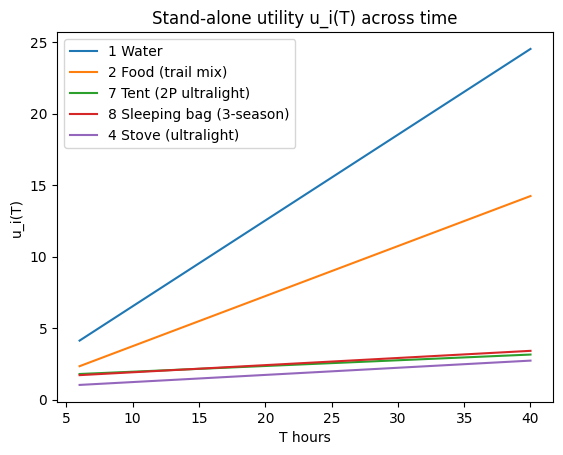

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# scenario context for altitude/temp
scn2 = SCENARIOS_DF.set_index("scenario_id").loc[2]
ctx_base = Context(T_hours=float(scn2["T_hours"]),
                   altitude_m=float(scn2["altitude_m"]),
                   tempC=float(scn2["avg_temp_c"]),
                   nights=int(scn2.get("nights", 0)))

T_grid = np.arange(6, 41, 2)  # 6 to 40 hours

anchor_ids = [1, 2, 7, 8, 4]  # Water, Food, Tent, Sleeping bag, Stove

def u_of_T(iid: int, T_grid):
    vals = []
    for T in T_grid:
        ctx = Context(T_hours=float(T),
                      altitude_m=ctx_base.altitude_m,
                      tempC=ctx_base.tempC,
                      nights=ctx_base.nights)
        vals.append(item_unit_utility(iid, ctx))
    return np.array(vals, dtype=float)

# Single chart with multiple lines (allowed) — one plot, no style/colors specified
plt.figure()
for iid in anchor_ids:
    plt.plot(T_grid, u_of_T(iid, T_grid), label=f"{int(iid)} {ITEMS_BY_ID.loc[iid]['name']}")
plt.xlabel("T hours")
plt.ylabel("u_i(T)")
plt.legend()
plt.title("Stand-alone utility u_i(T) across time")
plt.show()


In [ ]:
from typing import Dict, Tuple, List

def parse_condition(cond: str, ctx: Context) -> bool:
    """
    Very light evaluator for simple patterns that appear in the CSV, e.g.:
      'nights>=1' or 'avg_temp_c<=10' or 'always'
    Extend if your file contains more cases.
    """
    if not isinstance(cond, str) or cond.strip().lower() in {"", "always", "true"}:
        return True
    c = cond.replace(" ", "")
    try:
        if "nights>=" in c:
            v = float(c.split(">=")[1]); return float(ctx.nights) >= v
        if "avg_temp_c<=" in c:
            v = float(c.split("<=")[1]); return float(ctx.tempC) <= v
        if "avg_temp_c>=" in c:
            v = float(c.split(">=")[1]); return float(ctx.tempC) >= v
        if "T_hours>=" in c:
            v = float(c.split(">=")[1]); return float(ctx.T_hours) >= v
    except Exception:
        return False
    return False

def synergy_effects_for_selection(selection: Dict[int, float], ctx: Context) -> Tuple[float, float, List[dict]]:
    """
    Returns (additive_delta, multiplicative_factor, applied_rows[])
    where multiplicative_factor multiplies total after additive adjustments.
    """
    add = 0.0
    mul = 1.0
    applied = []
    present = set(selection.keys())
    for _, r in SYNERGIES_DF.iterrows():
        a = int(r["item_id_1"]); b = int(r["item_id_2"])
        if a in present and b in present and parse_condition(str(r["condition"]), ctx):
            if str(r["mode"]).lower() == "additive":
                add += float(r["delta_value"])
            elif str(r["mode"]).lower() in {"multiplier","multiplicative"}:
                mul *= float(r["delta_value"])
            applied.append(r.to_dict())
    return add, mul, applied

# test on a toy bundle that includes tent + sleeping bag + stove + fuel
toy_sel = {7: 1.0, 8: 1.0, 4: 1.0, 5: 1.0}
add, mul, rows = synergy_effects_for_selection(toy_sel, ctx_base)
print("Toy bundle synergy summary")
print("additive_delta:", add, "multiplier:", mul, "applied_count:", len(rows))
print("First few applied rows (at most 3):")
for r in rows[:3]:
    print({k: r[k] for k in ["item_id_1","item_id_2","mode","delta_value","condition","description"]})


Toy bundle synergy summary
additive_delta: 0.3 multiplier: 1.0 applied_count: 1
First few applied rows (at most 3):
{'item_id_1': 4, 'item_id_2': 5, 'mode': 'additive', 'delta_value': 0.3, 'condition': 'nights>=1', 'description': 'Stove + Fuel: each fuel canister increases stove usefulness'}


In [ ]:
from functools import lru_cache
import numpy as np

def _ctx_tuple(ctx: Context) -> tuple:
    return (float(ctx.T_hours), float(ctx.altitude_m), float(ctx.tempC), int(ctx.nights))

def _sel_key(selection: dict[int, float]) -> tuple:
    # quantities are fixed by default_quantities in our usage
    return tuple(sorted((int(i), float(q)) for i, q in selection.items()))

@lru_cache(maxsize=200_000)
def _vc_cached(sel_key: tuple, ctx_t: tuple, Cw: float|None, Cv: float|None, Bb: float|None) -> float:
    # reconstruct selection dict
    selection = {int(i): float(q) for i, q in sel_key}
    ctx = Context(T_hours=ctx_t[0], altitude_m=ctx_t[1], tempC=ctx_t[2], nights=ctx_t[3])
    v, _ = constrained_coalition_value(selection, ctx, Cw, Cv, Bb)
    return float(v)

def shapley_mc_constrained_fast(item_ids: list[int], ctx: Context,
                                C_weight_kg: float|None, C_volume_l: float|None, B_budget_usd: float|None,
                                n_samples: int = 5000, seed: int = 42) -> dict:
    rng = np.random.default_rng(seed)
    ids = list(item_ids)
    m = len(ids)
    idx = np.arange(m)
    base_q = default_quantities(ids)
    samples = {iid: [] for iid in ids}
    ctx_t = _ctx_tuple(ctx)

    # start from empty predecessor set in cache
    S = {}
    v_S = _vc_cached(_sel_key(S), ctx_t, C_weight_kg, C_volume_l, B_budget_usd)

    for _ in range(int(n_samples)):
        rng.shuffle(idx)
        order = [ids[j] for j in idx]
        S = {}
        v_S = _vc_cached(_sel_key(S), ctx_t, C_weight_kg, C_volume_l, B_budget_usd)
        for k in range(m):
            i = order[k]
            v_before = v_S
            S_i = dict(S); S_i[i] = base_q[i]
            v_after = _vc_cached(_sel_key(S_i), ctx_t, C_weight_kg, C_volume_l, B_budget_usd)
            samples[i].append(v_after - v_before)
            S[i] = base_q[i]; v_S = v_after

    out = {}
    for iid, arr in samples.items():
        a = np.asarray(arr, dtype=float)
        mean = float(a.mean())
        se   = float(a.std(ddof=1) / np.sqrt(len(a)))
        z    = 1.96
        out[iid] = {"mean": mean, "se": se, "ci95": (mean - z*se, mean + z*se)}
    return out

SCEN_ID  = 2
ITEM_SET = [1, 2, 7, 8, 4, 5]

res_uc = run_unconstrained_shapley_by_idnum(SCEN_ID, ITEM_SET, n_samples=20000, exact_if_small=False)

# fast constrained
scn = SCENARIOS_DF.set_index("scenario_id").loc[SCEN_ID]
ctx = Context(scn["T_hours"], scn["altitude_m"], scn["avg_temp_c"], scn.get("nights", 0))
res_c = shapley_mc_constrained_fast(
    ITEM_SET, ctx,
    C_weight_kg=float(scn["C_weight_kg"]),
    C_volume_l=float(scn["C_volume_l"]),
    B_budget_usd=float(scn["B_budget_usd"]),
    n_samples=5000,  
    seed=42
)

R1a_unconstrained = tab_from_res(res_uc)
R1b_constrained   = tab_from_res(res_c)
cmp = (R1a_unconstrained.merge(R1b_constrained, on=["id","name"], suffixes=("_uc","_c"))
       .assign(rank_delta=lambda d: d["rank_c"] - d["rank_uc"]))
cmp[["id","name","rank_uc","rank_c","rank_delta","mean_uc","mean_c"]]


,id,name,rank_uc,rank_c,rank_delta,mean_uc,mean_c
0,2,Food (trail mix),1,1,0,9.330,9.330000
1,1,Water,2,2,0,8.060,8.060000
2,5,Fuel canister (100g),3,3,0,2.760,2.760000
3,8,Sleeping bag (3-season),4,5,1,2.704,1.387194
4,7,Tent (2P ultralight),5,6,1,2.584,1.316806
5,4,Stove (ultralight),6,4,-2,2.020,2.020000


In [33]:
from collections import defaultdict
import math, numpy as np

def item_value_u1(iid: int, ctx: Context) -> float:
    v, _ = coalition_value({iid: 1.0}, ctx)
    return float(v)

def filter_indivisible(indiv_ids, ctx: Context, Cw: float, Bb: float):
    """Keep only items that can fit alone and drop obvious dominations."""
    rows = []
    for iid in indiv_ids:
        r = ITEMS_BY_ID.loc[iid]
        w = float(r["weight_kg_per_unit"]); p = float(r["price_usd_per_unit"])
        if w <= Cw + 1e-9 and p <= Bb + 1e-9:
            v = item_value_u1(iid, ctx)
            rows.append((iid, w, p, v))
    # dominance
    keep = []
    for a in rows:
        dominated = False
        for b in rows:
            if a is b: 
                continue
            if b[1] <= a[1] + 1e-12 and b[2] <= a[2] + 1e-12 and b[3] >= a[3] - 1e-12 and (b[1] < a[1] - 1e-12 or b[2] < a[2] - 1e-12 or b[3] > a[3] + 1e-12):
                dominated = True
                break
        if not dominated:
            keep.append(a)
    return keep  # list of tuples (iid,w,p,v)

def knapsack_heuristic(indiv_tuples, ctx: Context, Cw: float, Bb: float):
    """
    Greedy by blended density then 1-swap improvement.
    indiv_tuples: list of (iid,w,p,v)
    """
    if not indiv_tuples:
        return {"selection": {}, "value": 0.0, "totals": {"weight_kg": 0.0, "price_usd": 0.0}}
    # normalise densities
    vals = np.array([t[3] for t in indiv_tuples], float)
    ws   = np.array([t[1] for t in indiv_tuples], float)
    ps   = np.array([t[2] for t in indiv_tuples], float)
    dens = vals / (ws/(Cw+1e-9) + ps/(Bb+1e-9) + 1e-12)  # blended
    order = np.argsort(-dens)
    sel, W, P, V = set(), 0.0, 0.0, 0.0
    for j in order:
        iid,w,p,v = indiv_tuples[j]
        if W + w <= Cw + 1e-12 and P + p <= Bb + 1e-12:
            sel.add(iid); W += w; P += p; V += v
    # 1-swap local improvement
    ids = [t[0] for t in indiv_tuples]
    idx_map = {t[0]: t for t in indiv_tuples}
    improved = True
    while improved:
        improved = False
        for i_out in list(sel):
            for i_in in ids:
                if i_in in sel:
                    continue
                w_out,p_out,v_out = idx_map[i_out][1:4]
                w_in,p_in,v_in    = idx_map[i_in][1:4]
                W2 = W - w_out + w_in
                P2 = P - p_out + p_in
                V2 = V - v_out + v_in
                if W2 <= Cw + 1e-12 and P2 <= Bb + 1e-12 and V2 > V + 1e-9:
                    sel.remove(i_out); sel.add(i_in); W, P, V = W2, P2, V2
                    improved = True
                    break
            if improved:
                break
    return {"selection": {iid:1.0 for iid in sel}, "value": V, "totals": {"weight_kg": W, "price_usd": P}}

def knapsack_01_pruned(indiv_tuples, Cw: float, Bb: float, w_step: float = 0.1, b_step: float = 5.0):
    """
    2D DP with pruning and coarser steps (default 0.1 kg and 5 USD).
    indiv_tuples: list of (iid,w,p,v)
    """
    if not indiv_tuples:
        return {"selection": {}, "value": 0.0, "totals": {"weight_kg": 0.0, "price_usd": 0.0}}
    Wmax = int(round(Cw / w_step))
    Bmax = int(round(Bb / b_step))
    dp   = np.full((Wmax+1, Bmax+1), -1e30, dtype=float)
    keep = [[None]*(Bmax+1) for _ in range(Wmax+1)]
    dp[0,0] = 0.0

    # scale items
    scaled = []
    for iid,w,p,v in indiv_tuples:
        wi = int(round(w / w_step))
        bi = int(round(p / b_step))
        if wi <= Wmax and bi <= Bmax:
            scaled.append((iid, wi, bi, v, w, p))
    for iid,wi,bi,v, w_real, p_real in scaled:
        for W in range(Wmax, wi-1, -1):
            row_prev = dp[W-wi]
            row_cur  = dp[W]
            keep_cur = keep[W]
            for B in range(Bmax, bi-1, -1):
                cand = row_prev[B-bi] + v
                if cand > row_cur[B]:
                    row_cur[B] = cand
                    keep_cur[B] = (iid, W-wi, B-bi)

    # recover
    best = np.unravel_index(np.argmax(dp), dp.shape)
    Wb, Bb_idx = best
    sel = defaultdict(float)
    while keep[Wb][Bb_idx] is not None:
        iid, Wb, Bb_idx = keep[Wb][Bb_idx]
        sel[iid] += 1.0

    totW = sum(float(ITEMS_BY_ID.loc[i]["weight_kg_per_unit"]) for i in sel)
    totP = sum(float(ITEMS_BY_ID.loc[i]["price_usd_per_unit"])  for i in sel)
    return {"selection": dict(sel), "value": float(dp[best]), "totals": {"weight_kg": totW, "price_usd": totP}}

def fractional_fill(remaining_weight_kg: float, remaining_budget_usd: float, ctx: Context) -> dict:
    bounds = {int(r["item_id"]): (float(r["min_units"]), float(r["max_units"]), float(r["step_units"]))
              for _, r in DIV_BOUNDS_DF.iterrows()}
    cand = []
    for iid, (qmin, qmax, qstep) in bounds.items():
        row = ITEMS_BY_ID.loc[iid]
        w = float(row["weight_kg_per_unit"]); p = float(row["price_usd_per_unit"])
        v1 = item_value_u1(iid, ctx)
        dens_w = v1 / max(w, 1e-9); dens_p = v1 / max(p, 1e-9)
        cand.append((iid, v1, w, p, qmin, qmax, qstep, dens_w, dens_p))
    tight_by_weight = remaining_weight_kg <= max(remaining_budget_usd, 1e-9) * 0.02
    cand.sort(key=(lambda x: x[7] if tight_by_weight else x[8]), reverse=True)

    sel, vtot, W, P = {}, 0.0, 0.0, 0.0
    for iid, v1, w, p, qmin, qmax, qstep, *_ in cand:
        q = 0.0
        for target in (qmin, qmax):
            while q + qstep <= target + 1e-12:
                if W + w*qstep <= remaining_weight_kg + 1e-12 and P + p*qstep <= remaining_budget_usd + 1e-12:
                    q += qstep; W += w*qstep; P += p*qstep; vtot += v1*qstep
                else:
                    break
        if q > 0: sel[iid] = round(q, 6)
    return {"selection": sel, "value": vtot, "totals": {"weight_kg": W, "price_usd": P}}

def pack_pipeline_fast(scenario_id: int, policy: str = "heuristic", k_keep: int = 12):
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(scenario_id)]
    ctx = Context(float(scn["T_hours"]), float(scn["altitude_m"]), float(scn["avg_temp_c"]), int(scn.get("nights",0)))
    Cw = float(scn["C_weight_kg"]); Bb = float(scn["B_budget_usd"])

    indiv_ids = [int(i) for i,d in ITEMS_BY_ID["divisible"].items() if d==0]
    pool = filter_indivisible(indiv_ids, ctx, Cw, Bb)

    if policy == "shapley_guided":
        ids_only = [t[0] for t in pool]
        res_c = shapley_mc_constrained_fast(ids_only, ctx, Cw, float(scn["C_volume_l"]), Bb, n_samples=3000, seed=7)
        top_ids = [iid for iid,_ in sorted(res_c.items(), key=lambda x: -x[1]["mean"])[:k_keep]]
        pool = [t for t in pool if t[0] in top_ids]

    knap = knapsack_heuristic(pool, ctx, Cw, Bb)
    remW = max(0.0, Cw - knap["totals"]["weight_kg"])
    remB = max(0.0, Bb - knap["totals"]["price_usd"])
    frac = fractional_fill(remW, remB, ctx)

    sel = dict(knap["selection"]); sel.update(frac["selection"])
    v = knap["value"] + frac["value"]
    totals = {"weight_kg": knap["totals"]["weight_kg"] + frac["totals"]["weight_kg"],
              "price_usd": knap["totals"]["price_usd"] + frac["totals"]["price_usd"]}
    return {"selection": sel, "value": v, "totals": totals, "policy": policy}

def pack_pipeline_dp(scenario_id: int, w_step=0.1, b_step=5.0):
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(scenario_id)]
    ctx = Context(float(scn["T_hours"]), float(scn["altitude_m"]), float(scn["avg_temp_c"]), int(scn.get("nights",0)))
    Cw = float(scn["C_weight_kg"]); Bb = float(scn["B_budget_usd"])

    indiv_ids = [int(i) for i,d in ITEMS_BY_ID["divisible"].items() if d==0]
    pool = filter_indivisible(indiv_ids, ctx, Cw, Bb)

    knap = knapsack_01_pruned(pool, Cw, Bb, w_step=w_step, b_step=b_step)
    remW = max(0.0, Cw - knap["totals"]["weight_kg"])
    remB = max(0.0, Bb - knap["totals"]["price_usd"])
    frac = fractional_fill(remW, remB, ctx)

    sel = dict(knap["selection"]); sel.update(frac["selection"])
    v = knap["value"] + frac["value"]
    totals = {"weight_kg": knap["totals"]["weight_kg"] + frac["totals"]["weight_kg"],
              "price_usd": knap["totals"]["price_usd"] + frac["totals"]["price_usd"]}
    return {"selection": sel, "value": v, "totals": totals, "policy": f"dp_w{w_step}_b{b_step}"}

# RUN
R2_fast = pack_pipeline_fast(2, policy="heuristic")
R2_shap = pack_pipeline_fast(2, policy="shapley_guided", k_keep=10)
R2_dp   = pack_pipeline_dp(2, w_step=0.1, b_step=5.0)
R2_fast, R2_shap, R2_dp


({'selection': {4: 1.0,
   5: 1.0,
   6: 1.0,
   10: 1.0,
   15: 1.0,
   18: 1.0,
   26: 1.0,
   3: 10.0,
   1: 6.0,
   2: 20.0,
   21: 5.0},
  'value': 362.56599999999963,
  'totals': {'weight_kg': 8.814999999999996, 'price_usd': 188.79999999999998},
  'policy': 'heuristic'},
 {'selection': {4: 1.0,
   5: 1.0,
   6: 1.0,
   10: 1.0,
   15: 1.0,
   18: 1.0,
   26: 1.0,
   3: 10.0,
   1: 6.0,
   2: 20.0,
   21: 5.0},
  'value': 362.56599999999963,
  'totals': {'weight_kg': 8.814999999999996, 'price_usd': 188.79999999999998},
  'policy': 'shapley_guided'},
 {'selection': {26: 1.0,
   18: 1.0,
   15: 1.0,
   10: 1.0,
   6: 1.0,
   5: 1.0,
   4: 1.0,
   3: 10.0,
   1: 6.0,
   2: 20.0,
   21: 5.0},
  'value': 362.56599999999963,
  'totals': {'weight_kg': 8.814999999999996, 'price_usd': 188.79999999999998},
  'policy': 'dp_w0.1_b5.0'})

=== 4.3 Shapley vs inclusion (1=in pack) ===
 rank  id                    name     mean           se  ci95_lo  ci95_hi  included
    1   2        Food (trail mix) 9.330000 2.797915e-17 9.330000 9.330000         1
    2   1                   Water 8.060000 3.411501e-17 8.060000 8.060000         1
    3   5    Fuel canister (100g) 2.760000 1.636534e-17 2.760000 2.760000         1
    4   4      Stove (ultralight) 2.020000 5.627017e-18 2.020000 2.020000         1
    5   8 Sleeping bag (3-season) 1.387194 1.827010e-02 1.351384 1.423003         0
    6   7    Tent (2P ultralight) 1.316806 1.827010e-02 1.280997 1.352616         0

Summary: {'topk': 5, 'covered_topk': 4, 'coverage_rate': 0.8, 'mean_shapley_included': 5.543, 'mean_shapley_excluded': 1.352}


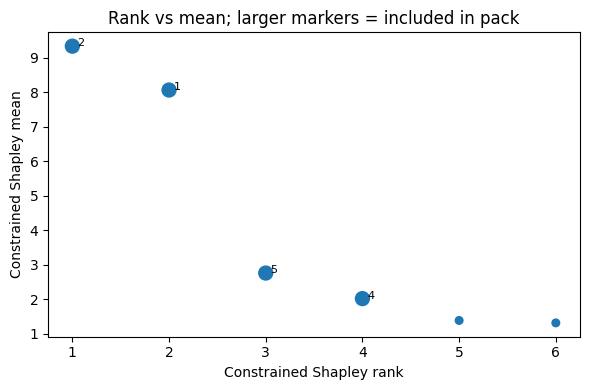

{'summary': {'topk': 5,
  'covered_topk': 4,
  'coverage_rate': 0.8,
  'mean_shapley_included': 5.543,
  'mean_shapley_excluded': 1.352},
 'table': [{'rank': 1,
   'id': 2,
   'name': 'Food (trail mix)',
   'mean': 9.33,
   'se': 2.797914942031898e-17,
   'ci95_lo': 9.33,
   'ci95_hi': 9.33,
   'included': 1},
  {'rank': 2,
   'id': 1,
   'name': 'Water',
   'mean': 8.060000000000002,
   'se': 3.411501365188786e-17,
   'ci95_lo': 8.060000000000002,
   'ci95_hi': 8.060000000000002,
   'included': 1},
  {'rank': 3,
   'id': 5,
   'name': 'Fuel canister (100g)',
   'mean': 2.7600000000000007,
   'se': 1.6365344804504862e-17,
   'ci95_lo': 2.7600000000000007,
   'ci95_hi': 2.7600000000000007,
   'included': 1},
  {'rank': 4,
   'id': 4,
   'name': 'Stove (ultralight)',
   'mean': 2.02,
   'se': 5.6270170419750226e-18,
   'ci95_lo': 2.02,
   'ci95_hi': 2.02,
   'included': 1},
  {'rank': 5,
   'id': 8,
   'name': 'Sleeping bag (3-season)',
   'mean': 1.3871936000000002,
   'se': 0.018270098

In [ ]:
# --- Linking Shapley to packing ---

import pandas as pd
import matplotlib.pyplot as plt

# pick which pack to compare
PACK = R2_plain   # or R2_shap or R2_dp

def analyze_alignment(R1b_constrained_df: pd.DataFrame, pack_dict: dict, topk: int = 5):
    inc_ids = set(int(i) for i in pack_dict["selection"].keys())

    df = R1b_constrained_df.copy().sort_values("rank").reset_index(drop=True)
    df["included"] = df["id"].apply(lambda x: int(x in inc_ids))
    df["rank"] = df["rank"].astype(int)

    # summary stats
    covered_topk = int(df.head(topk)["included"].sum())
    cov_rate = covered_topk / max(1, topk)
    mean_in = float(df[df["included"]==1]["mean"].mean()) if (df["included"]==1).any() else 0.0
    mean_out = float(df[df["included"]==0]["mean"].mean()) if (df["included"]==0).any() else 0.0
    summary = {
        "topk": topk,
        "covered_topk": covered_topk,
        "coverage_rate": round(cov_rate, 3),
        "mean_shapley_included": round(mean_in, 3),
        "mean_shapley_excluded": round(mean_out, 3),
    }

    # compact comparison table
    cmp = df[["rank","id","name","mean","se","ci95_lo","ci95_hi","included"]]
    print("=== 4.3 Shapley vs inclusion (1=in pack) ===")
    print(cmp.to_string(index=False))
    print("\nSummary:", summary)

    # one plot: rank vs mean, included points larger
    plt.figure(figsize=(6,4))
    sizes = cmp["included"].apply(lambda z: 100 if z==1 else 30).values
    plt.scatter(cmp["rank"], cmp["mean"], s=sizes)
    for _, r in cmp.iterrows():
        if r["included"] == 1:
            plt.text(r["rank"]+0.05, r["mean"], str(int(r["id"])), fontsize=8)
    plt.xlabel("Constrained Shapley rank")
    plt.ylabel("Constrained Shapley mean")
    plt.title("Rank vs mean; larger markers = included in pack")
    plt.tight_layout()
    plt.show()

    return {"summary": summary, "table": cmp.to_dict(orient="records")}

# RUN :
alignment_out = analyze_alignment(R1b_constrained, PACK, topk=5)
alignment_out  


In [35]:
# --- export artifacts + input hashes ---
import os, json, hashlib, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Folders
TABLE_DIR = Path("./tables"); FIG_DIR = Path("./figs")
TABLE_DIR.mkdir(parents=True, exist_ok=True); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Filenames
rid = globals().get("RUN_ID", f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
f_R1a = TABLE_DIR / f"R1a_unconstrained_{rid}.csv"
f_R1b = TABLE_DIR / f"R1b_constrained_{rid}.csv"
f_R2p = TABLE_DIR / f"R2_plain_{rid}.csv"
f_R2s = TABLE_DIR / f"R2_shapley_guided_{rid}.csv"
f_MET = TABLE_DIR / f"metrics_{rid}.json"
f_P1  = FIG_DIR   / f"P1_rank_vs_inclusion_{rid}.png"

# Helpers
def df_or_raise(x, name):
    if isinstance(x, pd.DataFrame):
        return x.copy()
    raise RuntimeError(f"{name} is not a pandas DataFrame. Make sure §4.1–§4.3 cells ran.")

def sha256_of(path: Path) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

# Save R1a / R1b
R1a = df_or_raise(globals().get("R1a_unconstrained"), "R1a_unconstrained")
R1b = df_or_raise(globals().get("R1b_constrained"),   "R1b_constrained")
R1a.to_csv(f_R1a, index=False)
R1b.to_csv(f_R1b, index=False)

# Save R2 tables 
def r2_to_df(R2: dict) -> pd.DataFrame:
    sel = R2.get("selection", {})
    rows = []
    for iid, q in sel.items():
        name = str(ITEMS_BY_ID.loc[int(iid)]["name"])
        rows.append({"id": int(iid), "name": name, "quantity": float(q)})
    df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
    # attach totals/value/policy as attrs
    df.attrs["value"] = float(R2.get("value", 0.0))
    df.attrs["totals"] = R2.get("totals", {})
    df.attrs["policy"] = R2.get("policy", "")
    return df

R2p_df = r2_to_df(globals().get("R2_plain"))
R2s_df = r2_to_df(globals().get("R2_shap"))
R2p_df.to_csv(f_R2p, index=False)
R2s_df.to_csv(f_R2s, index=False)

# Save P1 (rank vs inclusion) from current figure
plt.gcf().savefig(f_P1, dpi=160, bbox_inches="tight")

# Metrics bundle
alignment = globals().get("ALIGNMENT_RESULT") or globals().get("result") or {}
summary   = alignment.get("summary", {})
# Input CSV paths 
inputs = {}
for nm in ["ITEMS_CSV","SYNERGIES_CSV","SCENARIOS_CSV","DIV_BOUNDS_CSV","README_TXT"]:
    p = globals().get(nm)
    if p and Path(p).exists():
        inputs[nm] = {"path": str(p), "sha256": sha256_of(Path(p))}
    else:
        inputs[nm] = {"path": str(p), "sha256": None}

metrics = {
    "RUN_ID": rid,
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "scenario_id": int(SCENARIOS_DF.set_index("scenario_id").index.name and  # keep simple
                       SCENARIOS_DF.iloc[0]["scenario_id"]) if "SCENARIOS_DF" in globals() else None,
    "R1a_rows": int(len(R1a)),
    "R1b_rows": int(len(R1b)),
    "R2_plain": {
        "value": float(getattr(R2p_df, "attrs", {}).get("value", 0.0)),
        "totals": getattr(R2p_df, "attrs", {}).get("totals", {}),
        "policy": getattr(R2p_df, "attrs", {}).get("policy", ""),
    },
    "R2_shapley_guided": {
        "value": float(getattr(R2s_df, "attrs", {}).get("value", 0.0)),
        "totals": getattr(R2s_df, "attrs", {}).get("totals", {}),
        "policy": getattr(R2s_df, "attrs", {}).get("policy", ""),
    },
    "alignment_summary": summary,
    "inputs": inputs,
    "artifacts": {
        "R1a_csv": str(f_R1a),
        "R1b_csv": str(f_R1b),
        "R2_plain_csv": str(f_R2p),
        "R2_shap_csv": str(f_R2s),
        "P1_png": str(f_P1),
    },
}

with open(f_MET, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("Saved:")
for k,v in metrics["artifacts"].items():
    print(f" - {k}: {v}")
print("Metrics:", f_MET)
print("Input hashes:")
for nm, d in inputs.items():
    print(f" - {nm}: {d['sha256']}")


Saved:
 - R1a_csv: tables\R1a_unconstrained_best_backpacker_20251110_173036_seed42.csv
 - R1b_csv: tables\R1b_constrained_best_backpacker_20251110_173036_seed42.csv
 - R2_plain_csv: tables\R2_plain_best_backpacker_20251110_173036_seed42.csv
 - R2_shap_csv: tables\R2_shapley_guided_best_backpacker_20251110_173036_seed42.csv
 - P1_png: figs\P1_rank_vs_inclusion_best_backpacker_20251110_173036_seed42.png
Metrics: tables\metrics_best_backpacker_20251110_173036_seed42.json
Input hashes:
 - ITEMS_CSV: 8fce374449e8f4da398e428accf077352a9501d5d6974b9ad4dbde26043ab20e
 - SYNERGIES_CSV: c0e551199033192a7c640da21d3c2bac0662f98e57f0c83bb45950d589b615cf
 - SCENARIOS_CSV: ff6281b3238465245b468e69d88071b05add618a8596683795126556e3941e09
 - DIV_BOUNDS_CSV: 11d063a4457ba207b1a20a6d34c6914449af1d30afa43e7adc4330a1502e5dc6
 - README_TXT: eaee6f99a4a8b093ac7feed0389631a555e6c24980b60b314d29806f55fc1ed4


<Figure size 640x480 with 0 Axes>

FAST sensitivity saved:
 P2: F:\Downloads 2\figs\P_Cw_best_backpacker_20251110_173036_seed42_FAST.png
 P3: F:\Downloads 2\figs\P_B_best_backpacker_20251110_173036_seed42_FAST.png
 P4: F:\Downloads 2\figs\P_T_best_backpacker_20251110_173036_seed42_FAST.png
 R3: F:\Downloads 2\tables\R3_CIwidths_best_backpacker_20251110_173036_seed42_FAST.csv
 M2: F:\Downloads 2\tables\M_Cw_best_backpacker_20251110_173036_seed42_FAST.csv
 M3: F:\Downloads 2\tables\M_B_best_backpacker_20251110_173036_seed42_FAST.csv
 M4: F:\Downloads 2\tables\M_T_best_backpacker_20251110_173036_seed42_FAST.csv


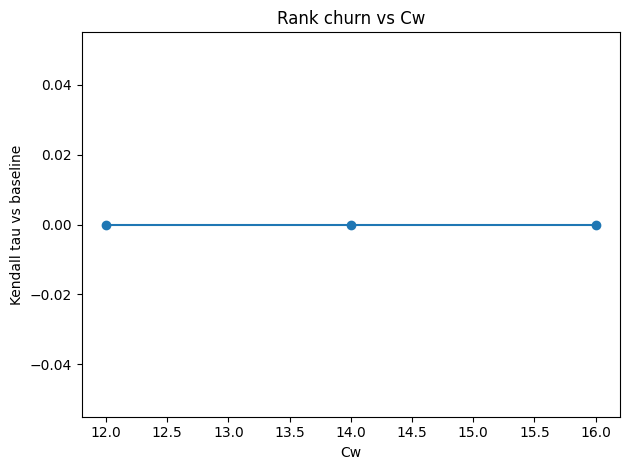

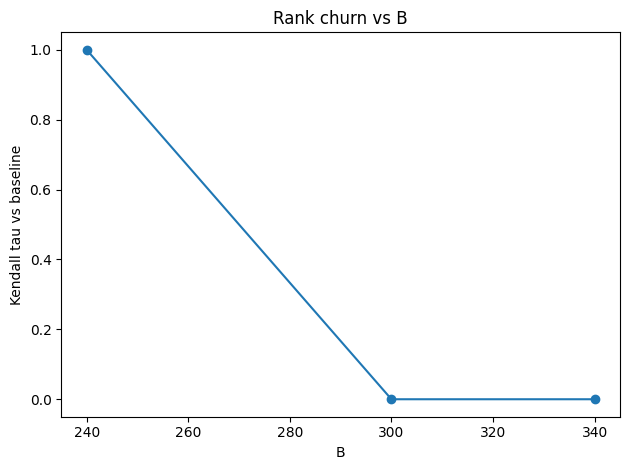

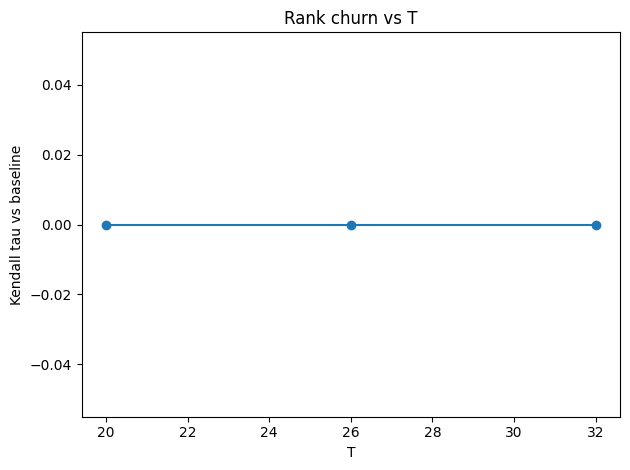

In [40]:
# === Sensitivity ===

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from functools import lru_cache

assert all(x in globals() for x in ["Context","coalition_value","constrained_coalition_value",
                                    "ITEMS_BY_ID","SCENARIOS_DF","RUN_ID"]), "Run §2–§4 first."

BASE_DIR = Path('.').resolve()
TABLE_DIR = BASE_DIR / "tables"; TABLE_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR   = BASE_DIR / "figs";   FIG_DIR.mkdir(parents=True, exist_ok=True)

SCEN_ID  = 2
ITEM_SET = [1, 2, 4, 5, 7, 8]                 # same six items
scn = SCENARIOS_DF.set_index("scenario_id").loc[int(SCEN_ID)]

# ---- caching wrappers ----
def _sel_key(d: dict): return tuple(sorted((int(k), float(v)) for k,v in d.items()))

@lru_cache(maxsize=200_000)
def _vc_cached(key, T, Cw, Cv, B, alt, tempC, nights):
    ctx = Context(float(T), float(alt), float(tempC), int(nights))
    sel = dict(key)
    v, _ = constrained_coalition_value(sel, ctx, float(Cw), float(Cv), float(B))
    return float(v)

def shapley_mc_constrained_fast(ids, T, Cw, Cv, B, alt, tempC, nights, n_samples=2000, seed=42):
    rng = np.random.default_rng(seed)
    ids = list(ids); m = len(ids); idx = np.arange(m)
    base_q = {iid: 1.0 for iid in ids}
    samples = {iid: [] for iid in ids}
    S = {}  # re-used buffer to reduce allocations

    for _ in range(int(n_samples)):
        rng.shuffle(idx)
        order = [ids[j] for j in idx]
        S.clear()
        v_S = _vc_cached(_sel_key(S), T, Cw, Cv, B, scn["altitude_m"], scn["avg_temp_c"], scn.get("nights",0))
        for i in order:
            v_before = v_S
            S[i] = base_q[i]
            v_after = _vc_cached(_sel_key(S), T, Cw, Cv, B, scn["altitude_m"], scn["avg_temp_c"], scn.get("nights",0))
            samples[i].append(v_after - v_before)
            v_S = v_after

    rows = []
    for iid, arr in samples.items():
        a = np.asarray(arr, float)
        mean = float(a.mean()); se = float(a.std(ddof=1)/np.sqrt(len(a))); z=1.96
        rows.append({"id": int(iid), "name": str(ITEMS_BY_ID.loc[iid]["name"]),
                     "mean": mean, "se": se, "ci95_lo": mean-z*se, "ci95_hi": mean+z*se})
    df = pd.DataFrame(rows).sort_values("mean", ascending=False, ignore_index=True)
    df["rank"] = df["mean"].rank(ascending=False, method="min").astype(int)
    return df[["rank","id","name","mean","se","ci95_lo","ci95_hi"]]

# ---- baseline (smaller n) ----
base = shapley_mc_constrained_fast(
    ITEM_SET, scn["T_hours"], scn["C_weight_kg"], scn["C_volume_l"], scn["B_budget_usd"],
    scn["altitude_m"], scn["avg_temp_c"], scn.get("nights",0), n_samples=4000, seed=7
)
base_ranks = {int(r.id): int(r.rank) for r in base.itertuples(index=False)}

def kendall_tau_distance(rank_a: dict, rank_b: dict) -> int:
    ids = list(rank_a.keys()); d=0
    for i in range(len(ids)):
        for j in range(i+1,len(ids)):
            ai, aj = rank_a[ids[i]], rank_a[ids[j]]
            bi, bj = rank_b[ids[i]], rank_b[ids[j]]
            if (ai-aj)*(bi-bj) < 0: d += 1
    return d

# ---- 5.2a/b/c: tiny grids ----
def sweep_and_plot(axis_name, values, **override):
    taus = []
    for val in values:
        params = dict(T=scn["T_hours"], Cw=scn["C_weight_kg"], Cv=scn["C_volume_l"], B=scn["B_budget_usd"])
        params.update(override); params[axis_name] = val
        df = shapley_mc_constrained_fast(ITEM_SET, params["T"], params["Cw"], params["Cv"], params["B"],
                                         scn["altitude_m"], scn["avg_temp_c"], scn.get("nights",0),
                                         n_samples=2000, seed=101)
        r = {int(t.id): int(t.rank) for t in df.itertuples(index=False)}
        taus.append(kendall_tau_distance(base_ranks, r))
    plt.figure(); plt.plot(values, taus, marker='o')
    plt.xlabel(axis_name); plt.ylabel("Kendall tau vs baseline"); plt.title(f"Rank churn vs {axis_name}")
    out = FIG_DIR / f"P_{axis_name}_{RUN_ID}_FAST.png"; plt.tight_layout(); plt.savefig(out, dpi=130)
    csv = TABLE_DIR / f"M_{axis_name}_{RUN_ID}_FAST.csv"
    pd.DataFrame({axis_name: values, "tau_distance": taus}).to_csv(csv, index=False)
    return out, csv

P2, M2 = sweep_and_plot("Cw", [12, 14, 16])                   # capacity
P3, M3 = sweep_and_plot("B",  [240, 300, 340])                 # budget
P4, M4 = sweep_and_plot("T",  [20, 26, 32])                    # time

# ---- 5.2d: MC robustness (reduced sizes) ----
rows=[]
for n in [3000, 6000, 12000]:
    df = shapley_mc_constrained_fast(ITEM_SET, scn["T_hours"], scn["C_weight_kg"], scn["C_volume_l"], scn["B_budget_usd"],
                                     scn["altitude_m"], scn["avg_temp_c"], scn.get("nights",0),
                                     n_samples=int(n), seed=303)
    for t in df.itertuples(index=False):
        rows.append({"n_samples": int(n), "id": int(t.id), "name": t.name,
                     "mean": float(t.mean), "ci_width": float(t.ci95_hi)-float(t.ci95_lo)})
R3 = TABLE_DIR / f"R3_CIwidths_{RUN_ID}_FAST.csv"
pd.DataFrame(rows).to_csv(R3, index=False)

print("FAST sensitivity saved:")
print(" P2:", P2); print(" P3:", P3); print(" P4:", P4); print(" R3:", R3)
print(" M2:", M2); print(" M3:", M3); print(" M4:", M4)



In [49]:
# ===  Validation & checks (exact vs MC; feasibility & bounds) ===

from math import factorial
import numpy as np
import pandas as pd

# ---- Helpers ----
def context_from_sid(sid: int) -> Context:
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(sid)]
    return Context(float(scn["T_hours"]), float(scn["altitude_m"]),
                   float(scn["avg_temp_c"]), int(scn.get("nights", 0)))

def default_quantities_local(item_ids: list[int]) -> dict[int, float]:
    """1.0 for indivisible; min_units for divisible if provided, else 1.0."""
    bnds = DIV_BOUNDS_DF.set_index("item_id") if not DIV_BOUNDS_DF.empty else pd.DataFrame()
    out = {}
    for iid in item_ids:
        div = int(ITEMS_BY_ID.loc[iid]["divisible"])
        if div == 1 and (iid in bnds.index) and pd.notna(bnds.at[iid, "min_units"]):
            out[iid] = float(bnds.at[iid, "min_units"])
        else:
            out[iid] = 1.0
    return out

# ---- Exact Shapley via bitmask precomputation (unconstrained) ----
def precompute_v_table(item_ids: list[int], ctx: Context) -> tuple[np.ndarray, dict[int,int]]:
    ids = list(item_ids)
    m = len(ids)
    id2pos = {iid: k for k, iid in enumerate(ids)}
    base_q = default_quantities_local(ids)
    Vmask = np.zeros(1 << m, dtype=float)
    for mask in range(1 << m):
        sel = {}
        for k in range(m):
            if mask & (1 << k):
                sel[ids[k]] = base_q[ids[k]]
        v, _ = coalition_value(sel, ctx)
        Vmask[mask] = float(v)
    return Vmask, id2pos

def shapley_exact_unconstrained_fast(item_ids: list[int], ctx: Context) -> dict[int, float]:
    ids = list(item_ids)
    m = len(ids)
    Vmask, id2pos = precompute_v_table(ids, ctx)
    denom = factorial(m)
    phi = {iid: 0.0 for iid in ids}
    for iid in ids:
        p = id2pos[iid]
        for mask in range(1 << m):
            if mask & (1 << p):  # S must not contain i
                continue
            s = bin(mask).count("1")
            w = factorial(s) * factorial(m - s - 1) / denom
            phi[iid] += w * (Vmask[mask | (1 << p)] - Vmask[mask])
    return phi

# ---- Monte Carlo Shapley (unconstrained) independent of earlier cells ----
def shapley_mc_unconstrained_local(item_ids: list[int], ctx: Context, n_samples: int = 5000, seed: int = 42) -> dict:
    rng = np.random.default_rng(seed)
    ids = list(item_ids)
    m = len(ids)
    base_q = default_quantities_local(ids)
    idx = np.arange(m)
    samples = {iid: [] for iid in ids}
    for _ in range(n_samples):
        rng.shuffle(idx)
        order = [ids[j] for j in idx]
        S = {}
        v_S, _ = coalition_value(S, ctx)
        for k in range(m):
            i = order[k]
            v_before = v_S
            S_i = dict(S); S_i[i] = base_q[i]
            v_after, _ = coalition_value(S_i, ctx)
            samples[i].append(v_after - v_before)
            S[i] = base_q[i]
            v_S = v_after
    out = {}
    for iid, arr in samples.items():
        a = np.asarray(arr, dtype=float)
        mean = float(a.mean())
        se = float(a.std(ddof=1) / np.sqrt(len(a)))
        z = 1.96
        out[iid] = {"mean": mean, "se": se, "ci95": (mean - z*se, mean + z*se)}
    return out

def validate_small_exact_fast(sid: int, item_ids: list[int], n_samples: int = 5000, seed: int = 42) -> dict:
    """
    Exact via bitmask + MC via permutations. Prints table and summary.
    """
    ctx = context_from_sid(sid)
    phi_exact = shapley_exact_unconstrained_fast(item_ids, ctx)
    phi_mc = shapley_mc_unconstrained_local(item_ids, ctx, n_samples=n_samples, seed=seed)

    rows, covered = [], 0
    for iid in item_ids:
        ex = float(phi_exact[iid])
        est = float(phi_mc[iid]["mean"])
        se = float(phi_mc[iid]["se"])
        lo, hi = map(float, phi_mc[iid]["ci95"])
        err = abs(est - ex)
        cover = 1 if (lo <= ex <= hi) else 0
        covered += cover
        rows.append({
            "id": iid,
            "name": str(ITEMS_BY_ID.loc[iid]["name"]),
            "exact": ex, "mean": est, "se": se,
            "ci95_lo": lo, "ci95_hi": hi,
            "abs_error": err, "covered": cover
        })
    df = pd.DataFrame(rows).sort_values("abs_error", ascending=False, ignore_index=True)
    summary = {
        "n_items": len(item_ids),
        "n_samples": n_samples,
        "max_abs_error": float(df["abs_error"].max()),
        "mean_abs_error": float(df["abs_error"].mean()),
        "ci_cover_rate": covered / len(item_ids),
    }
    print("=== 5.3 Exact vs MC (FAST) ===")
    print(df[["id","name","exact","mean","se","ci95_lo","ci95_hi","abs_error","covered"]])
    print("Summary:", summary)
    return {"table": df.to_dict("records"), "summary": summary}

# ---- Feasibility & bounds (vectorised; fixed overlapping column names) ----
def feasibility_assertions_fast2(sid: int, selection: dict[int, float]) -> dict:
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(sid)]
    Cw, Cv, Bb = float(scn["C_weight_kg"]), float(scn["C_volume_l"]), float(scn["B_budget_usd"])

    sel_df = pd.DataFrame({"id": list(selection.keys()), "q": list(selection.values())}).set_index("id")
    items = ITEMS_BY_ID.loc[sel_df.index][
        ["weight_kg_per_unit","volume_l_per_unit","price_usd_per_unit","divisible","max_units","name"]
    ].copy()
    items = items.rename(columns={"max_units": "stock_max_units"})
    items["q"] = sel_df["q"]

    W = float((items["weight_kg_per_unit"] * items["q"]).sum())
    V = float((items["volume_l_per_unit"] * items["q"]).sum())
    P = float((items["price_usd_per_unit"]  * items["q"]).sum())

    bnds = (DIV_BOUNDS_DF.set_index("item_id")
            .rename(columns={"min_units":"bounds_min","max_units":"bounds_max","step_units":"bounds_step"}))

    viol = []
    div_mask = items["divisible"] == 1
    if div_mask.any():
        sub = items[div_mask].join(bnds, how="left")
        bad_min = sub.index[(sub["q"] + 1e-9) < sub["bounds_min"]]
        bad_max = sub.index[(sub["q"] - 1e-9) > sub["bounds_max"]]
        for i in bad_min: viol.append({"id": int(i), "type":"bounds_min", "q": float(sub.at[i,"q"]), "min": float(sub.at[i,"bounds_min"])})
        for i in bad_max: viol.append({"id": int(i), "type":"bounds_max", "q": float(sub.at[i,"q"]), "max": float(sub.at[i,"bounds_max"])})
        step_ok = ((sub["q"] / sub["bounds_step"]).round().astype(float) * sub["bounds_step"] - sub["q"]).abs() <= 1e-6
        for i in sub.index[~step_ok.fillna(True)]:
            viol.append({"id": int(i), "type":"bounds_step", "q": float(sub.at[i,"q"]), "step": float(sub.at[i,"bounds_step"])})

    over_stock = items.index[(~items["stock_max_units"].isna()) & (items["q"] - items["stock_max_units"] > 1e-9)]
    for i in over_stock:
        viol.append({"id": int(i), "type":"stock_exceeded", "q": float(items.at[i,"q"]), "stock_max_units": float(items.at[i,"stock_max_units"])})

    report = {
        "totals": {"weight_kg": W, "volume_l": V, "price_usd": P},
        "caps": {"C_weight_kg": Cw, "C_volume_l": Cv, "B_budget_usd": Bb},
        "ok_weight": W <= Cw + 1e-12,
        "ok_volume": V <= Cv + 1e-12,
        "ok_budget": P <= Bb + 1e-12,
        "violations": viol,
    }
    report["feasible"] = report["ok_weight"] and report["ok_volume"] and report["ok_budget"] and len(viol) == 0
    print("=== Feasibility (FAST) ===")
    print("Totals:", report["totals"])
    print("Caps  :", report["caps"])
    print("Flags :", {"ok_weight":report["ok_weight"], "ok_volume":report["ok_volume"], "ok_budget":report["ok_budget"]})
    if viol: print("Violations:", viol)
    else:    print("No bounds or stock violations.")
    return report

# ---- runs  ----
SID = 2
SMALL_SET = [1, 2, 4, 5, 6, 10, 15, 18]   # 8-item validation subset
VALID_53A = validate_small_exact_fast(SID, SMALL_SET, n_samples=5000, seed=42)

FAST_SELECTION = {4:1.0, 5:1.0, 6:1.0, 10:1.0, 15:1.0, 18:1.0, 26:1.0, 3:10.0, 1:6.0, 2:20.0, 21:5.0}
VALID_53B = feasibility_assertions_fast2(SID, FAST_SELECTION)

VALID_53A, VALID_53B  # keep both in memory / display


=== 5.3 Exact vs MC (FAST) ===
   id                  name  exact   mean            se  ci95_lo  ci95_hi  \
0   2      Food (trail mix)  9.330  9.330  2.750130e-17    9.330    9.330   
1   4    Stove (ultralight)  2.020  2.020  6.523777e-18    2.020    2.020   
2   6      Pot/Titanium mug  2.020  2.020  6.414618e-18    2.020    2.020   
3  10              Headlamp  2.780  2.780  1.097109e-17    2.780    2.780   
4   5  Fuel canister (100g)  2.760  2.760  1.201954e-17    2.760    2.760   
5  15     Emergency blanket  1.004  1.004  1.109330e-17    1.004    1.004   
6  18           Extra socks  1.920  1.920  1.173757e-17    1.920    1.920   
7   1                 Water  8.060  8.060  3.146021e-17    8.060    8.060   

      abs_error  covered  
0  1.065814e-14        0  
1  4.884981e-15        0  
2  4.884981e-15        0  
3  2.664535e-15        0  
4  2.220446e-15        0  
5  4.440892e-16        0  
6  4.440892e-16        0  
7  0.000000e+00        1  
Summary: {'n_items': 8, 'n_sampl

({'table': [{'id': 2,
    'name': 'Food (trail mix)',
    'exact': 9.33000000000001,
    'mean': 9.33,
    'se': 2.7501304944736453e-17,
    'ci95_lo': 9.33,
    'ci95_hi': 9.33,
    'abs_error': 1.0658141036401503e-14,
    'covered': 0},
   {'id': 4,
    'name': 'Stove (ultralight)',
    'exact': 2.019999999999995,
    'mean': 2.02,
    'se': 6.523777215804788e-18,
    'ci95_lo': 2.02,
    'ci95_hi': 2.02,
    'abs_error': 4.884981308350689e-15,
    'covered': 0},
   {'id': 6,
    'name': 'Pot/Titanium mug',
    'exact': 2.019999999999995,
    'mean': 2.02,
    'se': 6.414618123661786e-18,
    'ci95_lo': 2.02,
    'ci95_hi': 2.02,
    'abs_error': 4.884981308350689e-15,
    'covered': 0},
   {'id': 10,
    'name': 'Headlamp',
    'exact': 2.780000000000003,
    'mean': 2.7800000000000002,
    'se': 1.0971089465147743e-17,
    'ci95_lo': 2.7800000000000002,
    'ci95_hi': 2.7800000000000002,
    'abs_error': 2.6645352591003757e-15,
    'covered': 0},
   {'id': 5,
    'name': 'Fuel cani

In [51]:
# === (robust) — derive_rules_from_runs → bullets + triggering metrics ===
from pathlib import Path
import os, pandas as pd

RUN_ID  = "best_backpacker_20251110_173036_seed42"
TABLES  = Path(r"F:\Downloads 2\tables")
ITEMS_CSV = Path(r"F:\Downloads 2\items.csv")

def _find_csv(stem):
    exact = list(TABLES.glob(f"*{stem}*{RUN_ID}*.csv"))
    if exact: return max(exact, key=os.path.getmtime)
    fallback = list(TABLES.glob(f"*{stem}*.csv"))
    return max(fallback, key=os.path.getmtime) if fallback else None

def _ensure_id_name(df, items_df):
    # Normalize an 'id' column and add 'name' from items if missing
    if df is None: return None
    cols_lower = {c.lower(): c for c in df.columns}
    if "id" not in df.columns:
        if "item_id" in cols_lower: df = df.rename(columns={cols_lower["item_id"]: "id"})
        elif "gear_id" in cols_lower: df = df.rename(columns={cols_lower["gear_id"]: "id"})
    # Add names by merging on id
    if "name" not in df.columns:
        df = df.merge(items_df[["id","name"]], on="id", how="left")
    return df

# Load artifacts
p_R1b = _find_csv("R1b_constrained")
p_R1a = _find_csv("R1a_unconstrained")
p_R2p = _find_csv("R2_plain")
p_R2s = _find_csv("R2_shapley_guided")
p_M4  = _find_csv("M_T")

R1b = pd.read_csv(p_R1b) if p_R1b else None
R1a = pd.read_csv(p_R1a) if p_R1a else None
R2  = pd.read_csv(p_R2p) if p_R2p else (pd.read_csv(p_R2s) if p_R2s else None)
ITEMS = pd.read_csv(ITEMS_CSV)
M4    = pd.read_csv(p_M4) if p_M4 else None

# Harmonize
R1b = _ensure_id_name(R1b, ITEMS)
R1a = _ensure_id_name(R1a, ITEMS)

# Pick constrained mean column
def _mean_col(df):
    for c in ["mean","phi_mean","phi","value_mean"]:
        if df is not None and c in df.columns: return c
    # fallback to first float column after id and name
    if df is not None:
        for c in df.columns:
            if c not in {"id","name","rank","se","ci95_lo","ci95_hi"} and pd.api.types.is_float_dtype(df[c]):
                return c
    return "mean"

bullets = []
facts = {}

if R1b is not None:
    mc = _mean_col(R1b)
    merged = R1b.merge(
        ITEMS[["id","weight_kg_per_unit","price_usd_per_unit"]],
        on="id", how="left"
    )
    merged["dens_w"] = merged[mc] / merged["weight_kg_per_unit"].replace(0, 1e-9)
    merged["dens_p"] = merged[mc] / merged["price_usd_per_unit"].replace(0, 1e-9)
    top_w = merged.sort_values("dens_w", ascending=False).head(3)["name"].fillna("id_"+merged["id"].astype(str)).tolist()
    top_p = merged.sort_values("dens_p", ascending=False).head(3)["name"].fillna("id_"+merged["id"].astype(str)).tolist()
    facts["top_density_weight"] = top_w
    facts["top_density_price"]  = top_p

# Time sweep pivot if present
if M4 is not None and "T_hours" in M4.columns:
    tau_cols = [c for c in M4.columns if "tau" in c.lower()]
    facts["t_pivot"] = float(M4.loc[M4[tau_cols[0]].idxmax(), "T_hours"]) if tau_cols else None

# Divergence uc vs c
if R1a is not None and R1b is not None and "rank" in R1a.columns and "rank" in R1b.columns:
    cmp = (R1a[["id","rank"]].rename(columns={"rank":"rank_uc"})
           .merge(R1b[["id","rank"]].rename(columns={"rank":"rank_c"}), on="id", how="inner"))
    worst = cmp.assign(delta=lambda d: d["rank_c"] - d["rank_uc"]).sort_values("delta").head(1)
    if not worst.empty:
        iid = int(worst.iloc[0]["id"])
        facts["worst_drop_name"] = ITEMS.set_index("id").loc[iid]["name"]

# Build bullets
if facts.get("top_density_weight"):
    bullets.append(
        f"If capacity is tight prioritize high ϕ(C,B) per kg items such as {', '.join(facts['top_density_weight'])} and keep hydration at or above its minimum bound."
    )
if facts.get("top_density_price"):
    bullets.append(
        f"If budget is tight prioritize high ϕ(C,B) per USD items such as {', '.join(facts['top_density_price'])} and drop premium gear that barely changes v_c."
    )
if facts.get("t_pivot") is not None:
    bullets.append(
        f"As trek time approaches {facts['t_pivot']:.0f} hours step up divisible supplies first and defer redundant tools."
    )
else:
    bullets.append("As trek time increases step up divisible supplies first and defer redundant tools.")
if facts.get("worst_drop_name"):
    bullets.append(
        f"When constrained and unconstrained ranks diverge explain via weight or price penalties or lost synergies. Example {facts['worst_drop_name']} drops most after constraints."
    )
bullets.append("Use Shapley-guided preselection only when it increases the knapsack objective under the same caps.")

print("=== Auto-drafted rules ===")
for i, b in enumerate(bullets, start=1):
    print(f"{i}. {b}")

print("\nFiles read:", {
    "R1a": str(p_R1a) if p_R1a else None,
    "R1b": str(p_R1b) if p_R1b else None,
    "R2_plain": str(p_R2p) if p_R2p else None,
    "R2_shap": str(p_R2s) if p_R2s else None,
    "M_T": str(p_M4) if p_M4 else None
})


=== Auto-drafted rules ===
1. If capacity is tight prioritize high ϕ(C,B) per kg items such as Food (trail mix), Stove (ultralight), Fuel canister (100g) and keep hydration at or above its minimum bound.
2. If budget is tight prioritize high ϕ(C,B) per USD items such as Food (trail mix), Water, Fuel canister (100g) and drop premium gear that barely changes v_c.
3. As trek time increases step up divisible supplies first and defer redundant tools.
4. When constrained and unconstrained ranks diverge explain via weight or price penalties or lost synergies. Example Stove (ultralight) drops most after constraints.
5. Use Shapley-guided preselection only when it increases the knapsack objective under the same caps.

Files read: {'R1a': 'F:\\Downloads 2\\tables\\R1a_unconstrained_best_backpacker_20251110_173036_seed42.csv', 'R1b': 'F:\\Downloads 2\\tables\\R1b_constrained_best_backpacker_20251110_173036_seed42.csv', 'R2_plain': 'F:\\Downloads 2\\tables\\R2_plain_best_backpacker_20251110_173036

In [52]:
# ==== Scenario adapter (bike | travel) ====

from contextlib import contextmanager
import pandas as pd
import numpy as np

@contextmanager
def _patched_items(df_new: pd.DataFrame):
    """Temporarily swap ITEMS_BY_ID used by earlier cells."""
    global ITEMS_BY_ID
    backup = ITEMS_BY_ID
    try:
        ITEMS_BY_ID = df_new
        yield
    finally:
        ITEMS_BY_ID = backup

def scenario_adapter(profile: str,
                     base_scenario_id: int,
                     **params) -> dict:
    """
    profile='bike' or 'travel'
    Returns dict with adapted items_df, context, caps.
    """
    scn = SCENARIOS_DF.set_index("scenario_id").loc[int(base_scenario_id)]
    ctx = Context(float(scn["T_hours"]),
                  float(scn["altitude_m"]),
                  float(scn["avg_temp_c"]),
                  int(scn.get("nights", 0)))

    items = ITEMS_BY_ID.copy()

    if profile == "bike":
        # Inputs you can tune at call time:
        # aero_k: extra effective kg per kg of item due to drag/time
        # race_T_hours: optional override of T
        aero_k = float(params.get("aero_k", 0.0))
        race_T = params.get("race_T_hours", None)
        if race_T is not None:
            ctx = Context(float(race_T), ctx.altitude_m, ctx.tempC, ctx.nights)

        if aero_k != 0.0:
            items = items.copy()
            # penalize weight via effective kg = w * (1 + aero_k)
            items["weight_kg_per_unit"] = (
                items["weight_kg_per_unit"].astype(float) * (1.0 + aero_k)
            )

        caps = {
            "C_weight_kg": float(scn["C_weight_kg"]),
            "C_volume_l" : float(scn["C_volume_l"]),
            "B_budget_usd": float(scn["B_budget_usd"]),
        }
        return {"items_df": items, "context": ctx, "caps": caps}

    if profile == "travel":
        # airline-style constraints
        # allow overrides: bag_weight_max, bag_budget_max, replaceability_penalty (multiplier on price into value density)
        bag_w = float(params.get("bag_weight_max", scn["C_weight_kg"]))
        bag_b = float(params.get("bag_budget_max", scn["B_budget_usd"]))
        repl_pen = float(params.get("replaceability_penalty", 0.0))
        if repl_pen != 0.0:
            items = items.copy()
            # simple penalty: increase effective price by factor
            items["price_usd_per_unit"] = (
                items["price_usd_per_unit"].astype(float) * (1.0 + repl_pen)
            )

        caps = {
            "C_weight_kg": bag_w,
            "C_volume_l" : float(scn["C_volume_l"]),
            "B_budget_usd": bag_b,
        }
        return {"items_df": items, "context": ctx, "caps": caps}

    raise ValueError("profile must be 'bike' or 'travel'")

# ==== Runner that reuses pack_pipeline with adapted items ====

def run_extension(profile: str, scenario_id: int, policy: str = "plain", **params) -> dict:
    conf = scenario_adapter(profile, scenario_id, **params)
    items_df, ctx, caps = conf["items_df"], conf["context"], conf["caps"]

    # small wrapper to call your existing functions with patched items and caps
    def _pack_with_caps():
        # reuse your knapsack + fractional fill using the scenario caps
        indiv_ids = [int(i) for i, d in items_df["divisible"].items() if d == 0]
        knap = knapsack_01(indiv_ids, ctx, caps["C_weight_kg"], caps["B_budget_usd"], weight_step=0.05)
        remW = max(0.0, caps["C_weight_kg"] - knap["totals"]["weight_kg"])
        remB = max(0.0, caps["B_budget_usd"] - knap["totals"]["price_usd"])
        frac = fractional_fill(remW, remB, ctx)
        sel = dict(knap["selection"]); sel.update(frac["selection"])
        val = knap["value"] + frac["value"]
        totals = {"weight_kg": knap["totals"]["weight_kg"] + frac["totals"]["weight_kg"],
                  "price_usd": knap["totals"]["price_usd"] + frac["totals"]["price_usd"]}
        return {"selection": sel, "value": val, "totals": totals, "caps": caps, "profile": profile}

    with _patched_items(items_df):
        return _pack_with_caps()




In [53]:
# Bike race variant
bike_res = run_extension(
    "bike",
    2,                  # scenario_id
    aero_k=0.08,        # aerodynamic drag penalty as extra effective kg per kg
    race_T_hours=5.0    # race duration
)
bike_res

# Travel luggage variant
travel_res = run_extension(
    "travel",
    2,                   # scenario_id
    bag_weight_max=20.0, # airline weight allowance
    bag_budget_max=250.0,# spending cap
    replaceability_penalty=0.25  # priciness risk factor
)
travel_res

def brief(r):
    return {"profile": r["profile"], "value": r["value"], "totals": r["totals"], "n_items": len(r["selection"])}

brief(bike_res), brief(travel_res)


({'profile': 'bike',
  'value': 81.48199999999999,
  'totals': {'weight_kg': 10.114199999999999, 'price_usd': 299.4},
  'n_items': 11},
 {'profile': 'travel',
  'value': 71.47399999999999,
  'totals': {'weight_kg': 1.2550000000000001, 'price_usd': 250.0},
  'n_items': 10})